In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pandas_datareader as web
import datetime as dt
import tensorflow as tf
import yfinance as yf
import os
import mplfinance as mpf
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Dense, Dropout, LSTM, InputLayer

## 1) Load the dataset

In [3]:
# Ensure the necessary directories exist
DATA_DIR = "data"  # Directory to save the data
if not os.path.exists(DATA_DIR):
    os.makedirs(DATA_DIR)
    
# Define constants outside the loop
COMPANY = 'CBA.AX'
DEFAULT_TRAIN_START = '2020-01-01'
DEFAULT_TRAIN_END = '2023-01-01'
while True:
    try:
        # Get training start date
        TRAIN_START = input(f"Enter training start date (YYYY-MM-DD) or press Enter for default '{DEFAULT_TRAIN_START}': ")
        if not TRAIN_START.strip():
            TRAIN_START = DEFAULT_TRAIN_START
        
        # Get training end date
        TRAIN_END = input(f"Enter training end date (YYYY-MM-DD) or press Enter for default '{DEFAULT_TRAIN_END}': ")
        if not TRAIN_END.strip():
            TRAIN_END = DEFAULT_TRAIN_END
        
        # Validate date format
        start_date = dt.datetime.strptime(TRAIN_START, '%Y-%m-%d')
        end_date = dt.datetime.strptime(TRAIN_END, '%Y-%m-%d')
        
        # Validate date range
        if start_date >= end_date:
            print("Error: Training end date must be after training start date.")
            continue
        
        print(f"Using training period: {TRAIN_START} to {TRAIN_END}")
        break  # Exit the loop if everything is valid
    
    except ValueError:
        print("Invalid date format. Please use YYYY-MM-DD format.")
        print(f"Using default values: {DEFAULT_TRAIN_START} to {DEFAULT_TRAIN_END}")
        TRAIN_START = DEFAULT_TRAIN_START
        TRAIN_END = DEFAULT_TRAIN_END
        break  # Or continue to ask again by removing this line

# Get the data for the stock AAPL
data = yf.download(COMPANY,TRAIN_START,TRAIN_END)
data_filename = f"{DATA_DIR}/{COMPANY}_data.csv"


# If it does not exist, save the data to the file
print(f"Saving data to {data_filename}")
data.to_csv(data_filename)
print(f"Data saved to {data_filename}")

Using training period: 2020-01-01 to 2023-01-01
YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed

Saving data to data/CBA.AX_data.csv
Data saved to data/CBA.AX_data.csv


## 2) Clean and preprocess the data

In [4]:
df = pd.read_csv(data_filename, skiprows=[1,2])

# Preprocess the data
# The columns actually contain: Date, Price, Close, High, Low, Volume
df.columns = ['Date', 'Price', 'Close', 'High', 'Low', 'Volume']

# Convert the 'Date' column to datetime
df['Date'] = pd.to_datetime(df['Date'])

# Convert the financial data columns to numeric
numeric_columns = ['Price', 'Close', 'High', 'Low', 'Volume']
for col in numeric_columns:
    df[col] = pd.to_numeric(df[col], errors='coerce')
    
# Save new cleaned data to a CSV file
cleaned_data_filename = f"{DATA_DIR}/{COMPANY}_cleaned_data.csv"
df.to_csv(cleaned_data_filename, index=False)
print(f"Cleaned data saved to {cleaned_data_filename}")

# Check few rows of the cleaned data
print("Cleaned Data Sample:")
print(df.head())


Cleaned data saved to data/CBA.AX_cleaned_data.csv
Cleaned Data Sample:
        Date      Price      Close       High        Low   Volume
0 2020-01-02  64.933319  65.209704  64.535007  64.860162  1416232
1 2020-01-03  65.282867  65.998211  65.234096  65.819375  1622784
2 2020-01-06  64.843895  64.933313  64.404942  64.811385  2129260
3 2020-01-07  66.006325  66.006325  65.177184  65.697430  2417468
4 2020-01-08  65.762474  66.046983  65.055261  66.022597  1719114


In [5]:
df = pd.read_csv(cleaned_data_filename)

def split_by_ratio_sequential(df, test_size_ratio):
    """Splits the data sequentially based on a ratio."""
    split_index = int(len(df) * (1 - test_size_ratio))
    train_data = df.iloc[:split_index]
    test_data = df.iloc[split_index:]
    return train_data, test_data

def split_by_date(df, cutoff_date):
    """Splits the data based on a specific cutoff date."""
    cutoff_date = pd.to_datetime(cutoff_date)
    train_data = df[df['Date'] < cutoff_date]
    test_data = df[df['Date'] >= cutoff_date]
    return train_data, test_data

def split_by_ratio_random(df, test_size_ratio):
    """Splits the data randomly based on a ratio."""
    train_data, test_data = train_test_split(df, test_size=test_size_ratio, random_state=42, shuffle=True)
    return train_data, test_data

while True:
    print("\nChoose a data splitting method:")
    print("1. Sequential split by ratio")
    print("2. Split by date")
    print("3. Random split by ratio")
    choice = input("Enter your choice (1/2/3): ")
    
    if choice == '1':
        ratio = float(input("Enter the test size ratio (e.g., 0.2 for 20%): "))
        test_ratio = ratio if 0 < ratio < 1 else 0.2
        train_data, test_data = split_by_ratio_sequential(df, test_ratio)
        print(f"Data split sequentially with {test_ratio*100}% for testing.")
        break
    elif choice == '2':
        cutoff_date = input("Enter the cutoff date (YYYY-MM-DD): ")
        train_data, test_data = split_by_date(df, cutoff_date)
        print(f"Data split by date with cutoff at {cutoff_date}.")
        break
    elif choice == '3':
        ratio = float(input("Enter the test size ratio (e.g., 0.2 for 20%): "))
        test_ratio = ratio if 0 < ratio < 1 else 0.2
        train_data, test_data = split_by_ratio_random(df, test_ratio)
        print(f"Data split randomly with {test_ratio*100}% for testing.")
        break
    else:
        print("Invalid choice. Please enter 1, 2, or 3.")
        
# Print the shapes of the train and test datasets
print(f"Train data shape: {train_data.shape}")
print(f"Test data shape: {test_data.shape}")


Choose a data splitting method:
1. Sequential split by ratio
2. Split by date
3. Random split by ratio
Data split sequentially with 20.0% for testing.
Train data shape: (608, 6)
Test data shape: (152, 6)


In [6]:
# Scale the feature columns and store scalers
from sklearn.preprocessing import MinMaxScaler
import pickle

# Define the feature columns to scale (excluding Date if it's a column)
feature_columns = ['Close', 'High', 'Low', 'Open', 'Volume']

# Dictionary to store scalers for each feature
scalers = {}
scaled_train_data = train_data.copy()
scaled_test_data = test_data.copy()

print("Scaling feature columns...")
for column in feature_columns:
    if column in train_data.columns:
        # Create a separate scaler for each feature
        scaler = MinMaxScaler(feature_range=(0, 1))
        
        # Fit the scaler on training data only
        scaled_train_data[column] = scaler.fit_transform(train_data[[column]])
        
        # Transform test data using the same scaler
        scaled_test_data[column] = scaler.transform(test_data[[column]])
        
        # Store the scaler in the dictionary
        scalers[column] = scaler
        
        print(f"Scaled column: {column}")
        print(f"  Original range: [{train_data[column].min():.4f}, {train_data[column].max():.4f}]")
        print(f"  Scaled range: [{scaled_train_data[column].min():.4f}, {scaled_train_data[column].max():.4f}]")

# Save scalers to file for future use
scalers_filename = f"{DATA_DIR}/{COMPANY}_scalers.pkl"
with open(scalers_filename, 'wb') as f:
    pickle.dump(scalers, f)
print(f"\nScalers saved to {scalers_filename}")

# Display scaling summary
print(f"\nScaling Summary:")
print(f"Number of features scaled: {len(scalers)}")
print(f"Scaled features: {list(scalers.keys())}")
print(f"Train data shape after scaling: {scaled_train_data.shape}")
print(f"Test data shape after scaling: {scaled_test_data.shape}")

# Function to load scalers from file
def load_scalers(filename):
    """Load scalers from pickle file"""
    try:
        with open(filename, 'rb') as f:
            return pickle.load(f)
    except FileNotFoundError:
        print(f"Scalers file {filename} not found!")
        return None

# Function to inverse transform scaled data
def inverse_transform_predictions(scaled_predictions, column_name, scalers_dict):
    """Inverse transform scaled predictions back to original scale"""
    if column_name in scalers_dict:
        scaler = scalers_dict[column_name]
        return scaler.inverse_transform(scaled_predictions.reshape(-1, 1)).flatten()
    else:
        print(f"Scaler for column '{column_name}' not found!")
        return scaled_predictions

# Example usage of loading scalers (for future sessions)
loaded_scalers = load_scalers(scalers_filename)
if loaded_scalers:
    print("Scalers loaded successfully!")

# Display sample of scaled data
print("\nSample of scaled training data:")
print(scaled_train_data.head())

print("\nSample of scaled test data:")
print(scaled_test_data.head())

Scaling feature columns...
Scaled column: Close
  Original range: [48.0495, 96.5344]
  Scaled range: [0.0000, 1.0000]
Scaled column: High
  Original range: [44.4250, 95.6616]
  Scaled range: [0.0000, 1.0000]
Scaled column: Low
  Original range: [46.5615, 96.2450]
  Scaled range: [0.0000, 1.0000]
Scaled column: Volume
  Original range: [350619.0000, 17021972.0000]
  Scaled range: [0.0000, 1.0000]

Scalers saved to data/CBA.AX_scalers.pkl

Scaling Summary:
Number of features scaled: 4
Scaled features: ['Close', 'High', 'Low', 'Volume']
Train data shape after scaling: (608, 6)
Test data shape after scaling: (152, 6)
Scalers loaded successfully!

Sample of scaled training data:
         Date      Price     Close      High       Low    Volume
0  2020-01-02  64.933319  0.353929  0.392493  0.368305  0.063919
1  2020-01-03  65.282867  0.370192  0.406138  0.387611  0.076308
2  2020-01-06  64.843895  0.348229  0.389955  0.367323  0.106688
3  2020-01-07  66.006325  0.370359  0.405027  0.385157  0

In [7]:
# Number of days to look back to base the prediction
PREDICTION_DAYS = 60 # Original

# Function to create the dataset with lookback
def create_dataset(data, look_back=1):
    """Create dataset with lookback feature"""
    X, y = [], []
    for i in range(len(data) - look_back):
        X.append(data[i:(i + look_back), :])
        y.append(data[i + look_back, 0])  # Assuming the first column is the target
    return np.array(X), np.array(y)

# 4) Build the model

In [8]:
import numpy as np
import pandas as pd
import os
import tensorflow as tf
from tensorflow.keras.models import load_model

# --- Configuration ---
# These variables should be defined in the earlier parts of your notebook.
# We define them here for completeness, but you should adjust them as needed.
COMPANY = 'CBA.AX'
PREDICTION_DAYS = 60 # Lookback window
DATA_DIR = "data"
MODEL_DIR = "models"
os.makedirs(MODEL_DIR, exist_ok=True)

# --- Prerequisite Check ---
# Ensure the necessary scaled data from the previous steps is available.
print("Checking for prerequisite data...")
try:
    # These should be created in your data preprocessing steps
    scaled_train_data
    scaled_test_data
    print("✅ Found 'scaled_train_data' and 'scaled_test_data'.")
except NameError:
    print("❌ Critical error: 'scaled_train_data' or 'scaled_test_data' not found.")
    print("Please run the data loading and preprocessing cells before this one.")
    # As a fallback for demonstration, we try to load them from the notebook's CSVs
    try:
        print("Attempting to load data from CSVs as a fallback...")
        train_data = pd.read_csv(f"{DATA_DIR}/{COMPANY}_cleaned_data.csv").iloc[:608] # Example split
        test_data = pd.read_csv(f"{DATA_DIR}/{COMPANY}_cleaned_data.csv").iloc[608:] # Example split
        # NOTE: This is a simplified scaling. In your actual notebook, you'd load saved scalers.
        from sklearn.preprocessing import MinMaxScaler
        feature_columns = ['Close', 'High', 'Low', 'Volume']
        scalers = {col: MinMaxScaler(feature_range=(0,1)) for col in feature_columns}
        scaled_train_data = train_data.copy()
        scaled_test_data = test_data.copy()
        for col in feature_columns:
            scaled_train_data[col] = scalers[col].fit_transform(train_data[[col]])
            scaled_test_data[col] = scalers[col].transform(test_data[[col]])
        print("✅ Fallback data loaded and scaled.")
    except Exception as e:
        print(f"❌ Fallback failed: {e}")
        raise

# --- Data Preparation for Models ---
# This part of the code prepares the data in the sequence format required by recurrent models.

# Correct feature columns based on the cleaning step. 'Open' was causing a KeyError.
# The available numeric columns after cleaning are ['Price', 'Close', 'High', 'Low', 'Volume']
# We will predict 'Close' price, and use others as features.
# Let's define the columns we will use for training. 'Close' must be the first one.
feature_columns = ['Close', 'High', 'Low', 'Volume']

# Select and convert data to numpy arrays
train_values = scaled_train_data[feature_columns].values
test_values = scaled_test_data[feature_columns].values

# Function to create sequences
def create_sequences(data, look_back):
    """Creates sequences and corresponding labels for time series forecasting."""
    X, y = [], []
    for i in range(look_back, len(data)):
        X.append(data[i-look_back:i, :]) # Sequence of 'look_back' days
        y.append(data[i, 0]) # The 'Close' price of the next day
    return np.array(X), np.array(y)

# Create training and testing sequences
X_train, y_train = create_sequences(train_values, PREDICTION_DAYS)
X_test, y_test = create_sequences(test_values, PREDICTION_DAYS)

print("\n--- Data Shapes for Modeling ---")
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")
print("---------------------------------")

# Validate input shape for the models
if X_train.shape[1] != PREDICTION_DAYS or X_train.shape[2] != len(feature_columns):
    raise ValueError("Data shape mismatch. Check PREDICTION_DAYS and feature_columns.")
else:
    print("\n✅ Data preparation complete. Ready for model building.")



Checking for prerequisite data...
✅ Found 'scaled_train_data' and 'scaled_test_data'.

--- Data Shapes for Modeling ---
X_train shape: (548, 60, 4)
y_train shape: (548,)
X_test shape: (92, 60, 4)
y_test shape: (92,)
---------------------------------

✅ Data preparation complete. Ready for model building.


In [9]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, SimpleRNN, Dense, Dropout, Input

def build_model(input_shape, layers_config, optimizer='adam', loss='mean_squared_error'):
    """
    Builds a Keras Sequential model based on a flexible layer configuration.

    Args:
        input_shape (tuple): The shape of the input data (e.g., (PREDICTION_DAYS, num_features)).
        layers_config (list): A list of dictionaries, where each dictionary defines a layer.
            Example: [
                {'type': 'lstm', 'units': 50, 'return_sequences': True, 'name': 'lstm_1'},
                {'type': 'dropout', 'rate': 0.2},
                {'type': 'dense', 'units': 25, 'activation': 'relu'},
            ]
        optimizer (str): The optimizer to use for compiling the model.
        loss (str): The loss function to use.

    Returns:
        tf.keras.Model: The compiled Keras model.
    """
    print(f"\nBuilding model with input shape: {input_shape}")
    model = Sequential()
    
    # Add the input layer explicitly
    model.add(Input(shape=input_shape))

    # Add layers based on the configuration
    for i, layer_info in enumerate(layers_config):
        layer_type = layer_info['type'].lower()
        layer_name = layer_info.get('name', f'{layer_type}_{i+1}')
        
        if layer_type == 'lstm':
            model.add(LSTM(
                units=layer_info['units'],
                return_sequences=layer_info.get('return_sequences', False),
                name=layer_name
            ))
            print(f" --> Added LSTM layer '{layer_name}' with {layer_info['units']} units.")
            
        elif layer_type == 'gru':
            model.add(GRU(
                units=layer_info['units'],
                return_sequences=layer_info.get('return_sequences', False),
                name=layer_name
            ))
            print(f" --> Added GRU layer '{layer_name}' with {layer_info['units']} units.")
            
        elif layer_type == 'rnn':
            model.add(SimpleRNN(
                units=layer_info['units'],
                return_sequences=layer_info.get('return_sequences', False),
                name=layer_name
            ))
            print(f" --> Added SimpleRNN layer '{layer_name}' with {layer_info['units']} units.")
            
        elif layer_type == 'dense':
            model.add(Dense(
                units=layer_info['units'],
                activation=layer_info.get('activation', 'relu'),
                name=layer_name
            ))
            print(f" --> Added Dense layer '{layer_name}' with {layer_info['units']} units.")
            
        elif layer_type == 'dropout':
            model.add(Dropout(
                rate=layer_info['rate'],
                name=layer_name
            ))
            print(f" --> Added Dropout layer '{layer_name}' with rate {layer_info['rate']}.")
            
        else:
            raise ValueError(f"Unknown layer type: {layer_type}")

    # Add the final output layer
    model.add(Dense(1, name='output_layer'))
    print(" --> Added final Dense output layer with 1 unit.")

    # Compile the model
    model.compile(optimizer=optimizer, loss=loss, metrics=['mae'])
    print("\nModel compilation complete.")
    
    model.summary()
    
    return model



In [10]:
# --- Experiment 1: Long Short-Term Memory (LSTM) Model ---

print("===== Starting Experiment 1: LSTM Model =====")

# 1. Define Model Architecture
lstm_layers = [
    {'type': 'lstm', 'units': 100, 'return_sequences': True, 'name': 'lstm_1'},
    {'type': 'dropout', 'rate': 0.2},
    {'type': 'lstm', 'units': 50, 'return_sequences': False, 'name': 'lstm_2'},
    {'type': 'dropout', 'rate': 0.2},
    {'type': 'dense', 'units': 25, 'activation': 'relu', 'name': 'dense_1'}
]

# 2. Define Hyperparameters
epochs = 50
batch_size = 32
model_filename = os.path.join(MODEL_DIR, f"{COMPANY}_lstm_model.keras")

# 3. Build the model
input_shape = (X_train.shape[1], X_train.shape[2])
lstm_model = build_model(input_shape, lstm_layers)

# 4. Train the model
print(f"\nTraining LSTM model for {epochs} epochs...")
history_lstm = lstm_model.fit(
    X_train, y_train,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(X_test, y_test),
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
        tf.keras.callbacks.ModelCheckpoint(model_filename, save_best_only=True, monitor='val_loss')
    ],
    verbose=1
)

# 5. Evaluate and Save
print("\n--- LSTM Model Evaluation ---")
loss, mae = lstm_model.evaluate(X_test, y_test, verbose=0)
print(f"Test Loss (MSE): {loss:.6f}")
print(f"Test Mean Absolute Error (MAE): {mae:.6f}")
print(f"Best model saved to: {model_filename}")
print("========================================\n")

# To load this model later:
# loaded_lstm_model = load_model(model_filename)


===== Starting Experiment 1: LSTM Model =====

Building model with input shape: (60, 4)
 --> Added LSTM layer 'lstm_1' with 100 units.
 --> Added Dropout layer 'dropout_2' with rate 0.2.
 --> Added LSTM layer 'lstm_2' with 50 units.
 --> Added Dropout layer 'dropout_4' with rate 0.2.
 --> Added Dense layer 'dense_1' with 25 units.
 --> Added final Dense output layer with 1 unit.

Model compilation complete.


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                   │ (None, 60, 100)        │        42,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 60, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 50)             │        30,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 25)             │         1,275 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 73,501 (287.11 KB)

 Trainable params: 73,501 (287.11 KB)

 Non-trainable params: 0 (0.00 B)


Training LSTM model for 50 epochs...
Epoch 1/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 50ms/step - loss: 0.1698 - mae: 0.3172 - val_loss: 0.0250 - val_mae: 0.1460
Epoch 2/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0150 - mae: 0.0992 - val_loss: 0.0106 - val_mae: 0.0895
Epoch 3/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 0.0089 - mae: 0.0705 - val_loss: 0.0038 - val_mae: 0.0510
Epoch 4/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 0.0063 - mae: 0.0605 - val_loss: 0.0038 - val_mae: 0.0507
Epoch 5/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.0071 - mae: 0.0637 - val_loss: 0.0027 - val_mae: 0.0439
Epoch 6/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.0057 - mae: 0.0569 - val_loss: 0.0069 - val_mae: 0.0700
Epoch 7/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.0052 - mae: 0.0543 - val_loss: 0.0020 - val_mae: 0.0396
Epoch 8/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0064 - mae: 0.0611 - val_loss: 0.0058 - val_mae: 0.0637
Epoch 9/50
18/18 ━━━━━━━━━

In [11]:
# --- Experiment 2: Gated Recurrent Unit (GRU) Model ---

print("===== Starting Experiment 2: GRU Model =====")

# 1. Define Model Architecture
gru_layers = [
    {'type': 'gru', 'units': 100, 'return_sequences': True, 'name': 'gru_1'},
    {'type': 'dropout', 'rate': 0.2},
    {'type': 'gru', 'units': 50, 'return_sequences': False, 'name': 'gru_2'},
    {'type': 'dropout', 'rate': 0.2},
    {'type': 'dense', 'units': 25, 'activation': 'relu', 'name': 'dense_1'}
]

# 2. Define Hyperparameters
epochs = 50
batch_size = 32
model_filename = os.path.join(MODEL_DIR, f"{COMPANY}_gru_model.keras")

# 3. Build the model
input_shape = (X_train.shape[1], X_train.shape[2])
gru_model = build_model(input_shape, gru_layers)

# 4. Train the model
print(f"\nTraining GRU model for {epochs} epochs...")
history_gru = gru_model.fit(
    X_train, y_train,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(X_test, y_test),
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
        tf.keras.callbacks.ModelCheckpoint(model_filename, save_best_only=True, monitor='val_loss')
    ],
    verbose=1
)

# 5. Evaluate and Save
print("\n--- GRU Model Evaluation ---")
loss, mae = gru_model.evaluate(X_test, y_test, verbose=0)
print(f"Test Loss (MSE): {loss:.6f}")
print(f"Test Mean Absolute Error (MAE): {mae:.6f}")
print(f"Best model saved to: {model_filename}")
print("======================================\n")

# To load this model later:
# loaded_gru_model = load_model(model_filename)


===== Starting Experiment 2: GRU Model =====

Building model with input shape: (60, 4)
 --> Added GRU layer 'gru_1' with 100 units.
 --> Added Dropout layer 'dropout_2' with rate 0.2.
 --> Added GRU layer 'gru_2' with 50 units.
 --> Added Dropout layer 'dropout_4' with rate 0.2.
 --> Added Dense layer 'dense_1' with 25 units.
 --> Added final Dense output layer with 1 unit.

Model compilation complete.


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru_1 (GRU)                     │ (None, 60, 100)        │        31,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 60, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_2 (GRU)                     │ (None, 50)             │        22,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 25)             │         1,275 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 55,901 (218.36 KB)

 Trainable params: 55,901 (218.36 KB)

 Non-trainable params: 0 (0.00 B)


Training GRU model for 50 epochs...
Epoch 1/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 55ms/step - loss: 0.3039 - mae: 0.4362 - val_loss: 0.0017 - val_mae: 0.0339
Epoch 2/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 0.0163 - mae: 0.1059 - val_loss: 0.0014 - val_mae: 0.0304
Epoch 3/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0123 - mae: 0.0913 - val_loss: 0.0075 - val_mae: 0.0793
Epoch 4/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0075 - mae: 0.0659 - val_loss: 0.0048 - val_mae: 0.0613
Epoch 5/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.0055 - mae: 0.0574 - val_loss: 0.0012 - val_mae: 0.0291
Epoch 6/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0062 - mae: 0.0580 - val_loss: 0.0012 - val_mae: 0.0285
Epoch 7/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.0041 - mae: 0.0481 - val_loss: 0.0021 - val_mae: 0.0374
Epoch 8/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.0052 - mae: 0.0531 - val_loss: 0.0018 - val_mae: 0.0344
Epoch 9/50
18/18 ━━━━━━━━━━

In [12]:
# --- Experiment 3: Simple Recurrent Neural Network (RNN) Model ---

print("===== Starting Experiment 3: Simple RNN Model =====")

# 1. Define Model Architecture
rnn_layers = [
    {'type': 'rnn', 'units': 100, 'return_sequences': True, 'name': 'rnn_1'},
    {'type': 'dropout', 'rate': 0.3}, # Increased dropout for simpler models
    {'type': 'rnn', 'units': 50, 'return_sequences': False, 'name': 'rnn_2'},
    {'type': 'dropout', 'rate': 0.3},
    {'type': 'dense', 'units': 25, 'activation': 'relu', 'name': 'dense_1'}
]

# 2. Define Hyperparameters
epochs = 75 # Might need more epochs for simple RNN to converge
batch_size = 32
model_filename = os.path.join(MODEL_DIR, f"{COMPANY}_rnn_model.keras")

# 3. Build the model
input_shape = (X_train.shape[1], X_train.shape[2])
rnn_model = build_model(input_shape, rnn_layers)

# 4. Train the model
print(f"\nTraining Simple RNN model for {epochs} epochs...")
history_rnn = rnn_model.fit(
    X_train, y_train,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(X_test, y_test),
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
        tf.keras.callbacks.ModelCheckpoint(model_filename, save_best_only=True, monitor='val_loss')
    ],
    verbose=1
)

# 5. Evaluate and Save
print("\n--- Simple RNN Model Evaluation ---")
loss, mae = rnn_model.evaluate(X_test, y_test, verbose=0)
print(f"Test Loss (MSE): {loss:.6f}")
print(f"Test Mean Absolute Error (MAE): {mae:.6f}")
print(f"Best model saved to: {model_filename}")
print("=============================================\n")

# To load this model later:
# loaded_rnn_model = load_model(model_filename)


===== Starting Experiment 3: Simple RNN Model =====

Building model with input shape: (60, 4)
 --> Added SimpleRNN layer 'rnn_1' with 100 units.
 --> Added Dropout layer 'dropout_2' with rate 0.3.
 --> Added SimpleRNN layer 'rnn_2' with 50 units.
 --> Added Dropout layer 'dropout_4' with rate 0.3.
 --> Added Dense layer 'dense_1' with 25 units.
 --> Added final Dense output layer with 1 unit.

Model compilation complete.


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rnn_1 (SimpleRNN)               │ (None, 60, 100)        │        10,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 60, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rnn_2 (SimpleRNN)               │ (None, 50)             │         7,550 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 25)             │         1,275 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,351 (75.59 KB)

 Trainable params: 19,351 (75.59 KB)

 Non-trainable params: 0 (0.00 B)


Training Simple RNN model for 75 epochs...
Epoch 1/75
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 0.1623 - mae: 0.3212 - val_loss: 0.0040 - val_mae: 0.0537
Epoch 2/75
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0532 - mae: 0.1846 - val_loss: 0.0140 - val_mae: 0.1070
Epoch 3/75
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0451 - mae: 0.1680 - val_loss: 0.0200 - val_mae: 0.1297
Epoch 4/75
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0323 - mae: 0.1450 - val_loss: 0.0056 - val_mae: 0.0654
Epoch 5/75
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0248 - mae: 0.1260 - val_loss: 0.0050 - val_mae: 0.0619
Epoch 6/75
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0249 - mae: 0.1259 - val_loss: 0.0080 - val_mae: 0.0779
Epoch 7/75
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0168 - mae: 0.1065 - val_loss: 0.0108 - val_mae: 0.0986
Epoch 8/75
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0174 - mae: 0.1025 - val_loss: 0.0064 - val_mae: 0.0745
Epoch 9/75
18/18 ━━━

# 5) Make predictions on the test set

--- Loading Trained Models ---
✅ Successfully loaded 3 models: LSTM, GRU, and RNN.

--- Loading Data Scaler ---
✅ Scaler for 'Close' price loaded successfully.

--- Making Predictions on Test Data ---
 > Predicting with LSTM model...
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
 > Predicting with GRU model...
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
 > Predicting with RNN model...
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
✅ Predictions complete for all models.

--- De-scaling Predictions for Comparison ---
✅ De-scaled LSTM predictions.
✅ De-scaled GRU predictions.
✅ De-scaled RNN predictions.

--- Overall Prediction Performance Metrics ---
       MAE ($)     MSE  RMSE ($)
Model                           
LSTM    1.7007  3.8867    1.9715
GRU     1.3804  2.8014    1.6737
RNN     1.6354  3.9075    1.9768



--- Detailed Analysis for LSTM Model ---
✅ Predictions for LSTM model saved to: data\CBA.AX_predictions_LSTM.csv


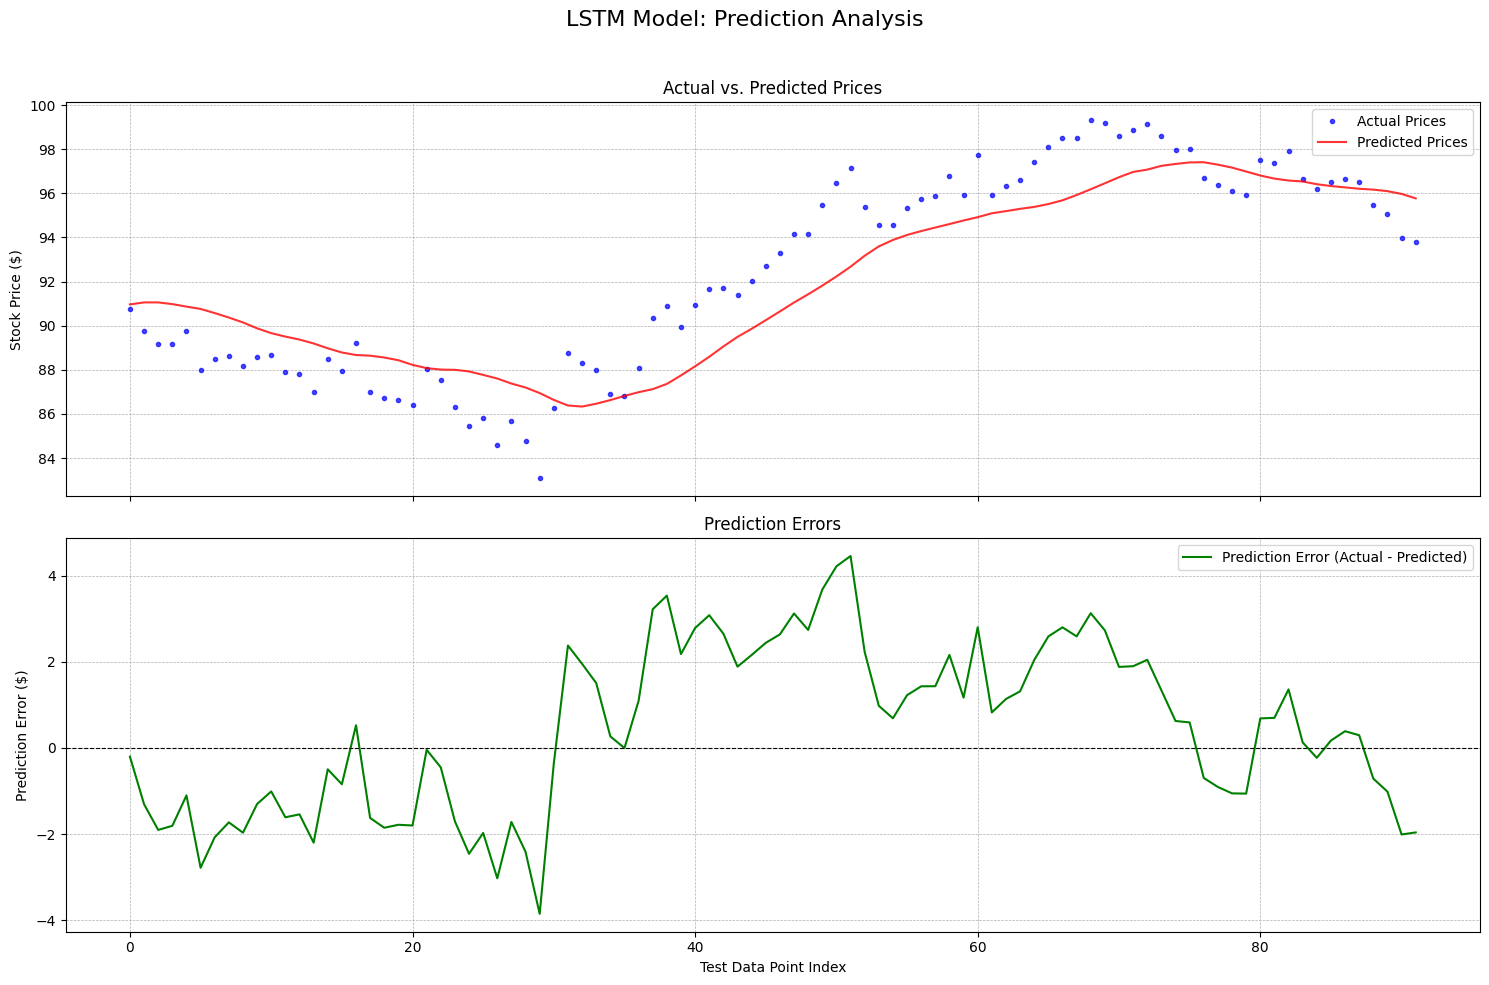


--- Prediction Highlights & Lowlights ---

✅ 5 Best Predictions (Lowest Absolute Error):
    Actual_Price  Predicted_Price  Error  Absolute_Error
35         86.82        86.820000  -0.00            0.00
21         88.03        88.080002  -0.04            0.04
83         96.66        96.540001   0.13            0.13
85         96.50        96.330002   0.17            0.17
0          90.76        90.959999  -0.20            0.20

❌ 5 Worst Predictions (Highest Absolute Error):
    Actual_Price  Predicted_Price  Error  Absolute_Error
51         97.13        92.669998   4.46            4.46
50         96.45        92.230003   4.22            4.22
29         83.10        86.949997  -3.85            3.85
49         95.49        91.820000   3.68            3.68
38         90.90        87.360001   3.54            3.54

--- Statistical Summary of Errors ---
count    92.0000
mean      0.4280
std       1.9350
min      -3.8503
25%      -1.3019
50%       0.5605
75%       2.0748
max       4.4563
Na

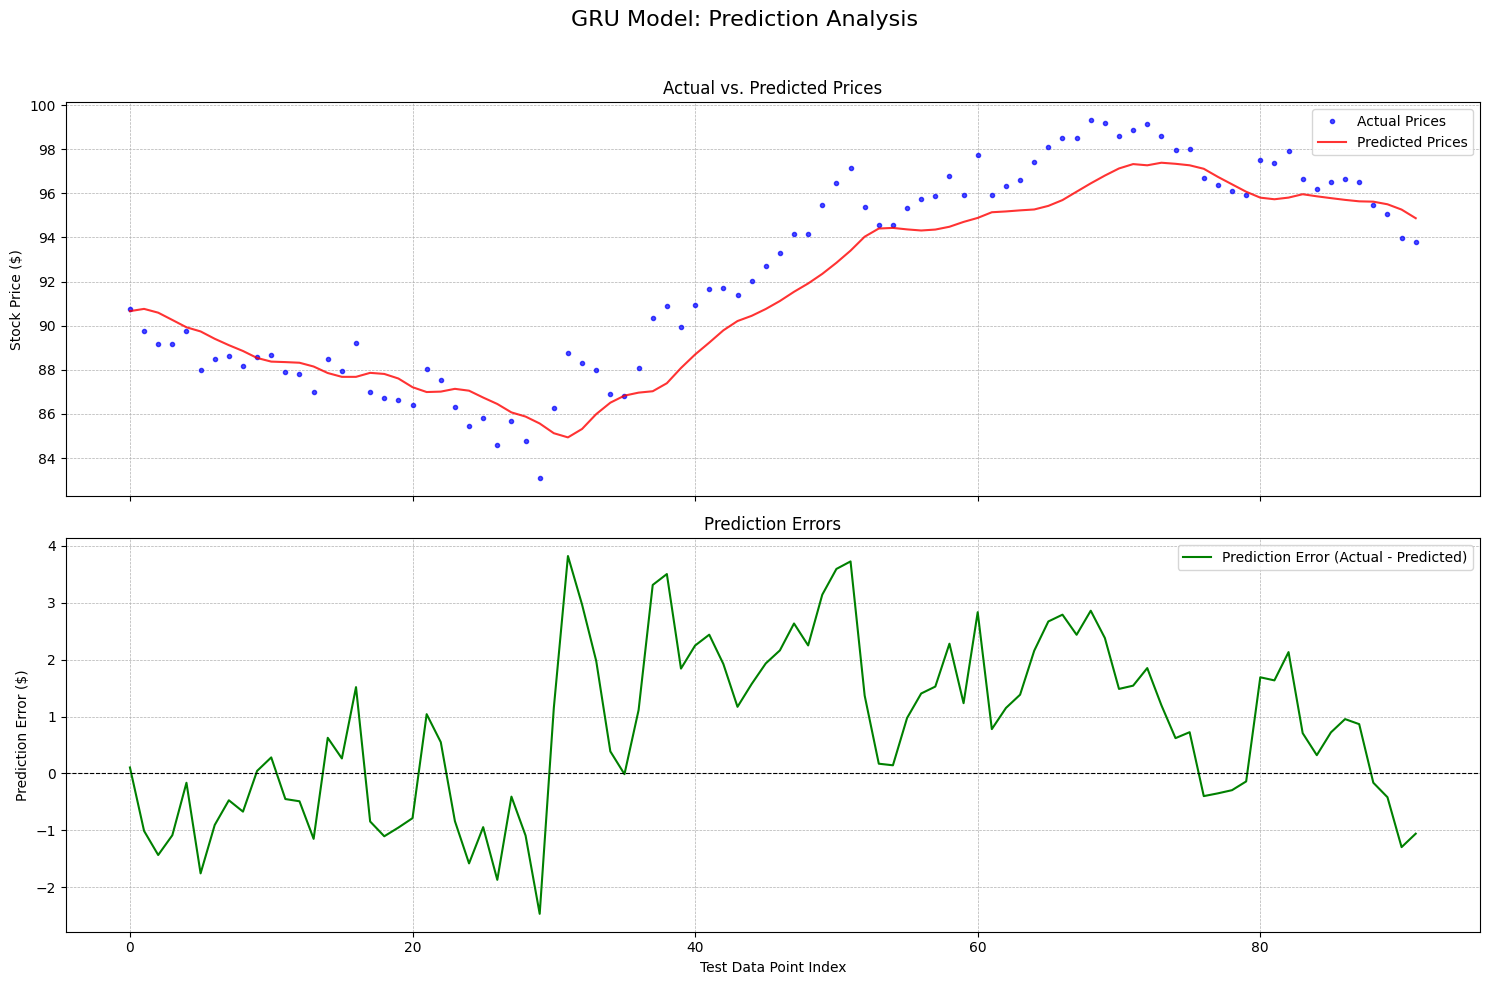


--- Prediction Highlights & Lowlights ---

✅ 5 Best Predictions (Lowest Absolute Error):
    Actual_Price  Predicted_Price  Error  Absolute_Error
35         86.82        86.830002  -0.01            0.01
9          88.58        88.540001   0.04            0.04
0          90.76        90.660004   0.10            0.10
54         94.57        94.430000   0.14            0.14
79         95.93        96.070000  -0.14            0.14

❌ 5 Worst Predictions (Highest Absolute Error):
    Actual_Price  Predicted_Price  Error  Absolute_Error
31         88.76        84.940002   3.82            3.82
51         97.13        93.400002   3.73            3.73
50         96.45        92.849998   3.60            3.60
38         90.90        87.389999   3.51            3.51
37         90.34        87.029999   3.31            3.31

--- Statistical Summary of Errors ---
count    92.0000
mean      0.8002
std       1.4781
min      -2.4720
25%      -0.4125
50%       0.8218
75%       1.9259
max       3.8237
Na

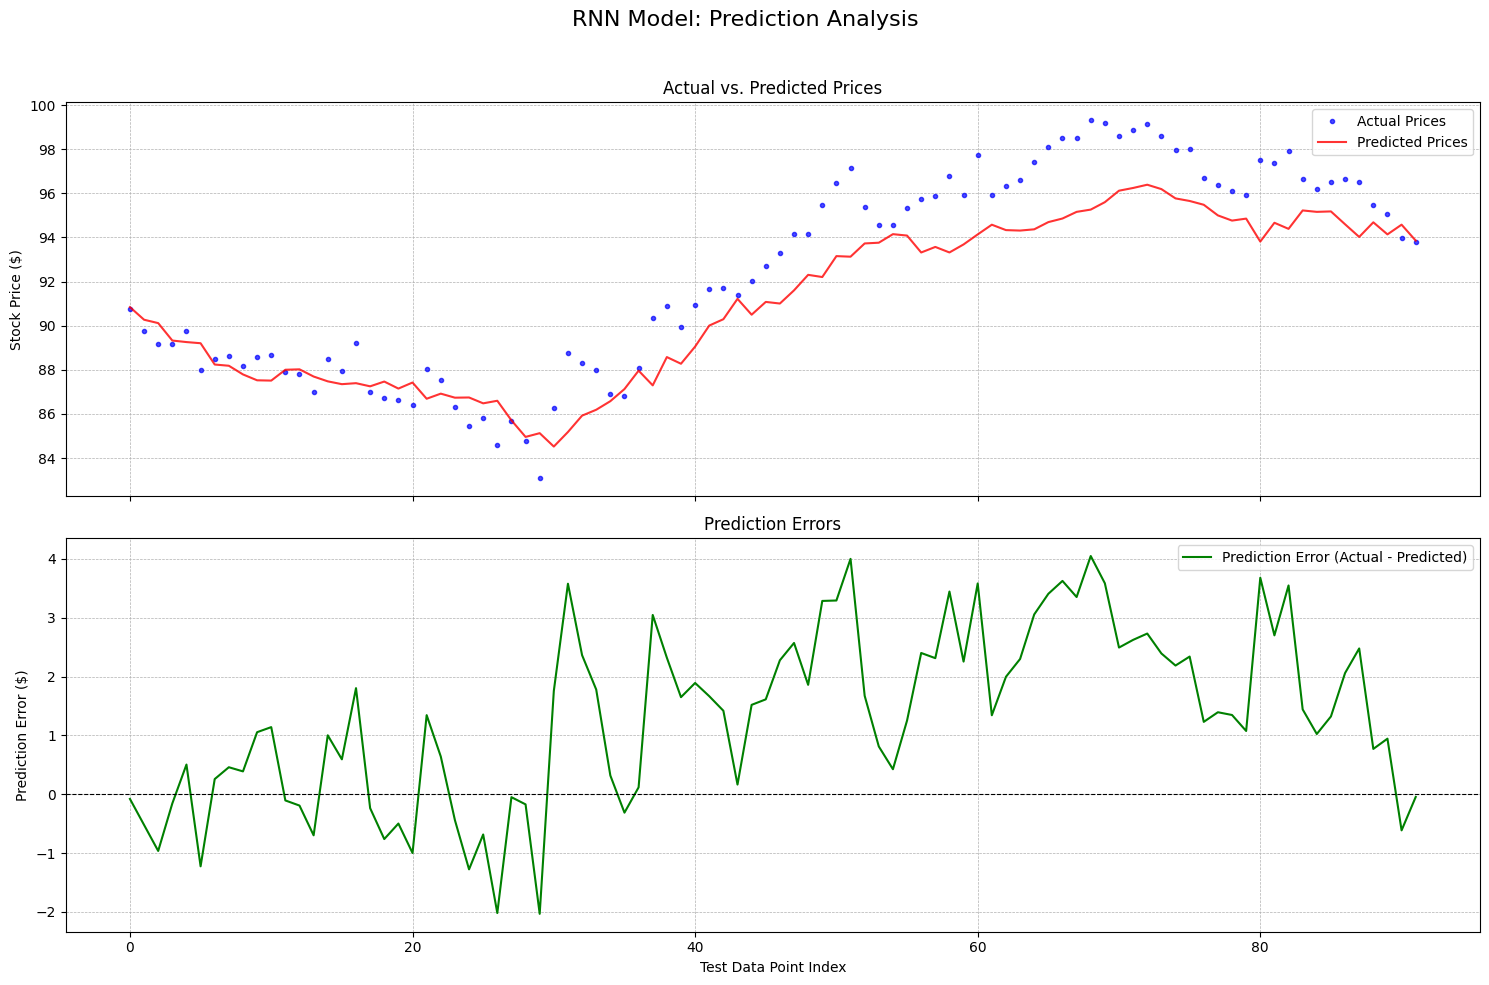


--- Prediction Highlights & Lowlights ---

✅ 5 Best Predictions (Lowest Absolute Error):
    Actual_Price  Predicted_Price  Error  Absolute_Error
91         93.81        93.860001  -0.05            0.05
27         85.66        85.709999  -0.05            0.05
0          90.76        90.839996  -0.08            0.08
11         87.90        88.000000  -0.11            0.11
36         88.08        87.959999   0.12            0.12

❌ 5 Worst Predictions (Highest Absolute Error):
    Actual_Price  Predicted_Price  Error  Absolute_Error
68         99.31        95.260002   4.05            4.05
51         97.13        93.129997   4.00            4.00
80         97.49        93.809998   3.68            3.68
66         98.48        94.860001   3.63            3.63
69         99.18        95.599998   3.59            3.59

--- Statistical Summary of Errors ---
count    92.0000
mean      1.3291
std       1.4713
min      -2.0333
25%       0.1524
50%       1.3706
75%       2.3718
max       4.0500
Na

In [15]:
import numpy as np
import os
import pickle
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from sklearn.metrics import mean_squared_error, mean_absolute_error

# --- Configuration ---
COMPANY = 'CBA.AX'
DATA_DIR = "data"
MODEL_DIR = "models"

# --- 1. Load the Trained Models ---
print("--- Loading Trained Models ---")
try:
    # Define model paths
    lstm_model_path = os.path.join(MODEL_DIR, f"{COMPANY}_lstm_model.keras")
    gru_model_path = os.path.join(MODEL_DIR, f"{COMPANY}_gru_model.keras")
    rnn_model_path = os.path.join(MODEL_DIR, f"{COMPANY}_rnn_model.keras")

    # Load the models
    lstm_model = load_model(lstm_model_path)
    gru_model = load_model(gru_model_path)
    rnn_model = load_model(rnn_model_path)
    
    print(f"✅ Successfully loaded 3 models: LSTM, GRU, and RNN.")
    models = {'LSTM': lstm_model, 'GRU': gru_model, 'RNN': rnn_model}

except Exception as e:
    print(f"❌ Error loading models: {e}")
    print("Please ensure that the training cells have been run and the .keras files are saved in the 'models' directory.")
    # Stop execution if models can't be loaded
    raise

# --- 2. Load the Scaler ---
# The scaler is needed to inverse transform the predictions back to actual prices.
print("\n--- Loading Data Scaler ---")
try:
    scalers_filename = f"{DATA_DIR}/{COMPANY}_scalers.pkl"
    with open(scalers_filename, 'rb') as f:
        scalers = pickle.load(f)
    # We specifically need the scaler for the 'Close' price, which was our target variable.
    close_scaler = scalers['Close']
    print("✅ Scaler for 'Close' price loaded successfully.")
except Exception as e:
    print(f"❌ Error loading scalers: {e}")
    print("The 'scalers.pkl' file is required to understand the model's output.")
    # Stop execution if scaler isn't found
    raise

# --- 3. Make Predictions on the Test Set ---
print("\n--- Making Predictions on Test Data ---")
predictions = {}
# Add a check for X_test existence
if 'X_test' not in locals():
    raise NameError("Variable 'X_test' not found. Please run the data preparation cell.")
    
for name, model in models.items():
    print(f" > Predicting with {name} model...")
    predictions[name] = model.predict(X_test)

print("✅ Predictions complete for all models.")

# --- 4. Inverse Transform Predictions and Actual Values ---
# The model predicts scaled values. We need to revert them to their original scale (dollars).
print("\n--- De-scaling Predictions for Comparison ---")

# De-scale the actual test values (y_test) for comparison
if 'y_test' not in locals():
    raise NameError("Variable 'y_test' not found. Please run the data preparation cell.")
actual_prices = close_scaler.inverse_transform(y_test.reshape(-1, 1))

# De-scale the predicted values from each model
descaled_predictions = {}
for name, pred in predictions.items():
    descaled_predictions[name] = close_scaler.inverse_transform(pred)
    print(f"✅ De-scaled {name} predictions.")

# --- 5. Calculate and Display Overall Prediction Metrics ---
print("\n--- Overall Prediction Performance Metrics ---")
metrics = []
for name, pred_prices in descaled_predictions.items():
    mae = mean_absolute_error(actual_prices, pred_prices)
    mse = mean_squared_error(actual_prices, pred_prices)
    rmse = np.sqrt(mse)
    metrics.append({'Model': name, 'MAE ($)': mae, 'MSE': mse, 'RMSE ($)': rmse})

metrics_df = pd.DataFrame(metrics)
metrics_df.set_index('Model', inplace=True)

print(metrics_df.round(4))
print("=============================================\n")


# --- 6. Detailed Analysis for Each Model ---
for name, pred_prices in descaled_predictions.items():
    print(f"\n\n--- Detailed Analysis for {name} Model ---")
    print("=================================================")
    
    # Create a results DataFrame for the current model
    results_df = pd.DataFrame({
        'Actual_Price': actual_prices.flatten(),
        'Predicted_Price': pred_prices.flatten()
    })
    results_df['Error'] = results_df['Actual_Price'] - results_df['Predicted_Price']
    results_df['Absolute_Error'] = np.abs(results_df['Error'])
    
    # a. Save predictions to CSV
    predictions_filename = os.path.join(DATA_DIR, f"{COMPANY}_predictions_{name}.csv")
    results_df.to_csv(predictions_filename, index=False)
    print(f"✅ Predictions for {name} model saved to: {predictions_filename}")

    # b. Visualize predictions vs actual and c. Plot prediction errors
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10), sharex=True)
    fig.suptitle(f'{name} Model: Prediction Analysis', fontsize=16)

    # Plotting actual vs predicted
    ax1.plot(results_df.index, results_df['Actual_Price'], label='Actual Prices', color='blue', marker='.', linestyle='', alpha=0.7)
    ax1.plot(results_df.index, results_df['Predicted_Price'], label='Predicted Prices', color='red', linestyle='-', alpha=0.8)
    ax1.set_ylabel('Stock Price ($)')
    ax1.set_title('Actual vs. Predicted Prices')
    ax1.legend()
    ax1.grid(True, which='both', linestyle='--', linewidth=0.5)

    # Plotting prediction errors
    ax2.plot(results_df.index, results_df['Error'], label='Prediction Error (Actual - Predicted)', color='green', linestyle='-')
    ax2.axhline(y=0, color='black', linestyle='--', linewidth=0.8)
    ax2.set_xlabel('Test Data Point Index')
    ax2.set_ylabel('Prediction Error ($)')
    ax2.set_title('Prediction Errors')
    ax2.legend()
    ax2.grid(True, which='both', linestyle='--', linewidth=0.5)
    
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

    # d. Additional analysis: Best and worst predictions
    print("\n--- Prediction Highlights & Lowlights ---")
    best_predictions = results_df.nsmallest(5, 'Absolute_Error')
    worst_predictions = results_df.nlargest(5, 'Absolute_Error')
    
    print("\n✅ 5 Best Predictions (Lowest Absolute Error):")
    print(best_predictions.round(2))
    
    print("\n❌ 5 Worst Predictions (Highest Absolute Error):")
    print(worst_predictions.round(2))

    # e. Statistical summary of errors
    print("\n--- Statistical Summary of Errors ---")
    print(results_df['Error'].describe().round(4))
    print("----------------------------------------")

--- Loading Trained Models ---
✅ Successfully loaded 3 models: LSTM, GRU, and RNN.

--- Loading Data Scaler ---
✅ Scaler for 'Close' price loaded successfully.

--- Making Predictions on Test Data ---
 > Predicting with LSTM model...
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 145ms/step
 > Predicting with GRU model...
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 171ms/step
 > Predicting with RNN model...
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
✅ Predictions complete for all models.

--- De-scaling Predictions for Comparison ---
✅ De-scaled LSTM predictions.
✅ De-scaled GRU predictions.
✅ De-scaled RNN predictions.

--- Overall Prediction Performance Metrics ---
       MAE ($)     MSE  RMSE ($)
Model                           
LSTM    1.7007  3.8867    1.9715
GRU     1.3804  2.8014    1.6737
RNN     1.6354  3.9075    1.9768



--- Detailed Analysis for LSTM Model ---
✅ Predictions for LSTM model saved to: data\CBA.AX_predictions_LSTM.csv


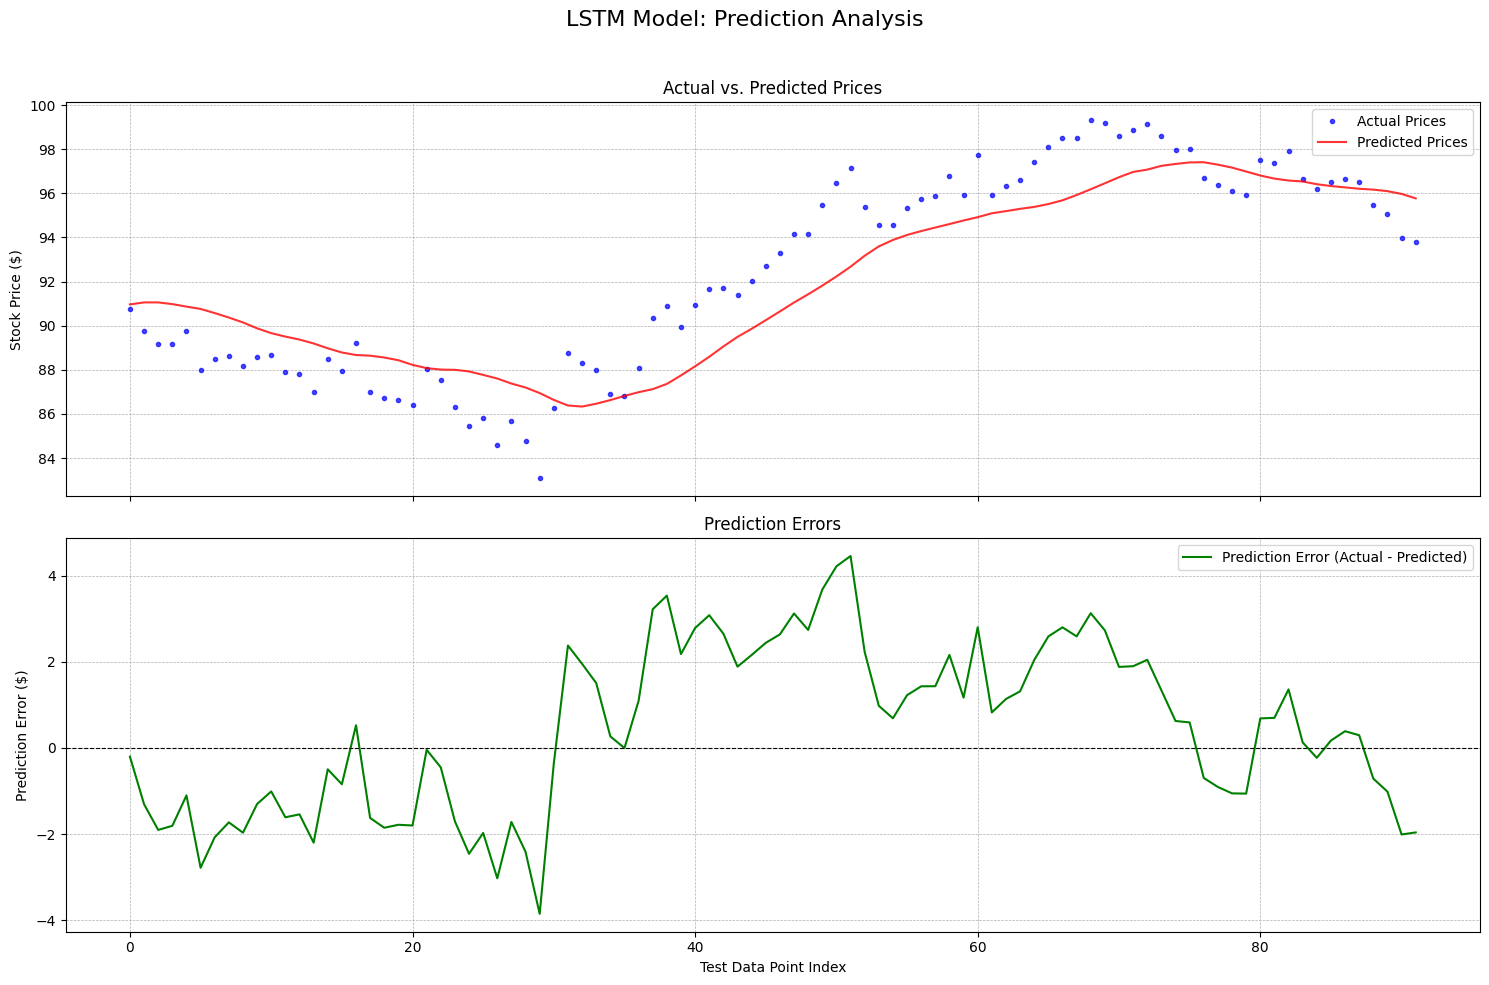


--- Prediction Highlights & Lowlights ---

✅ 5 Best Predictions (Lowest Absolute Error):
    Actual_Price  Predicted_Price  Error  Absolute_Error
35         86.82        86.820000  -0.00            0.00
21         88.03        88.080002  -0.04            0.04
83         96.66        96.540001   0.13            0.13
85         96.50        96.330002   0.17            0.17
0          90.76        90.959999  -0.20            0.20

❌ 5 Worst Predictions (Highest Absolute Error):
    Actual_Price  Predicted_Price  Error  Absolute_Error
51         97.13        92.669998   4.46            4.46
50         96.45        92.230003   4.22            4.22
29         83.10        86.949997  -3.85            3.85
49         95.49        91.820000   3.68            3.68
38         90.90        87.360001   3.54            3.54

--- Statistical Summary of Errors ---
count    92.0000
mean      0.4280
std       1.9350
min      -3.8503
25%      -1.3019
50%       0.5605
75%       2.0748
max       4.4563
Na

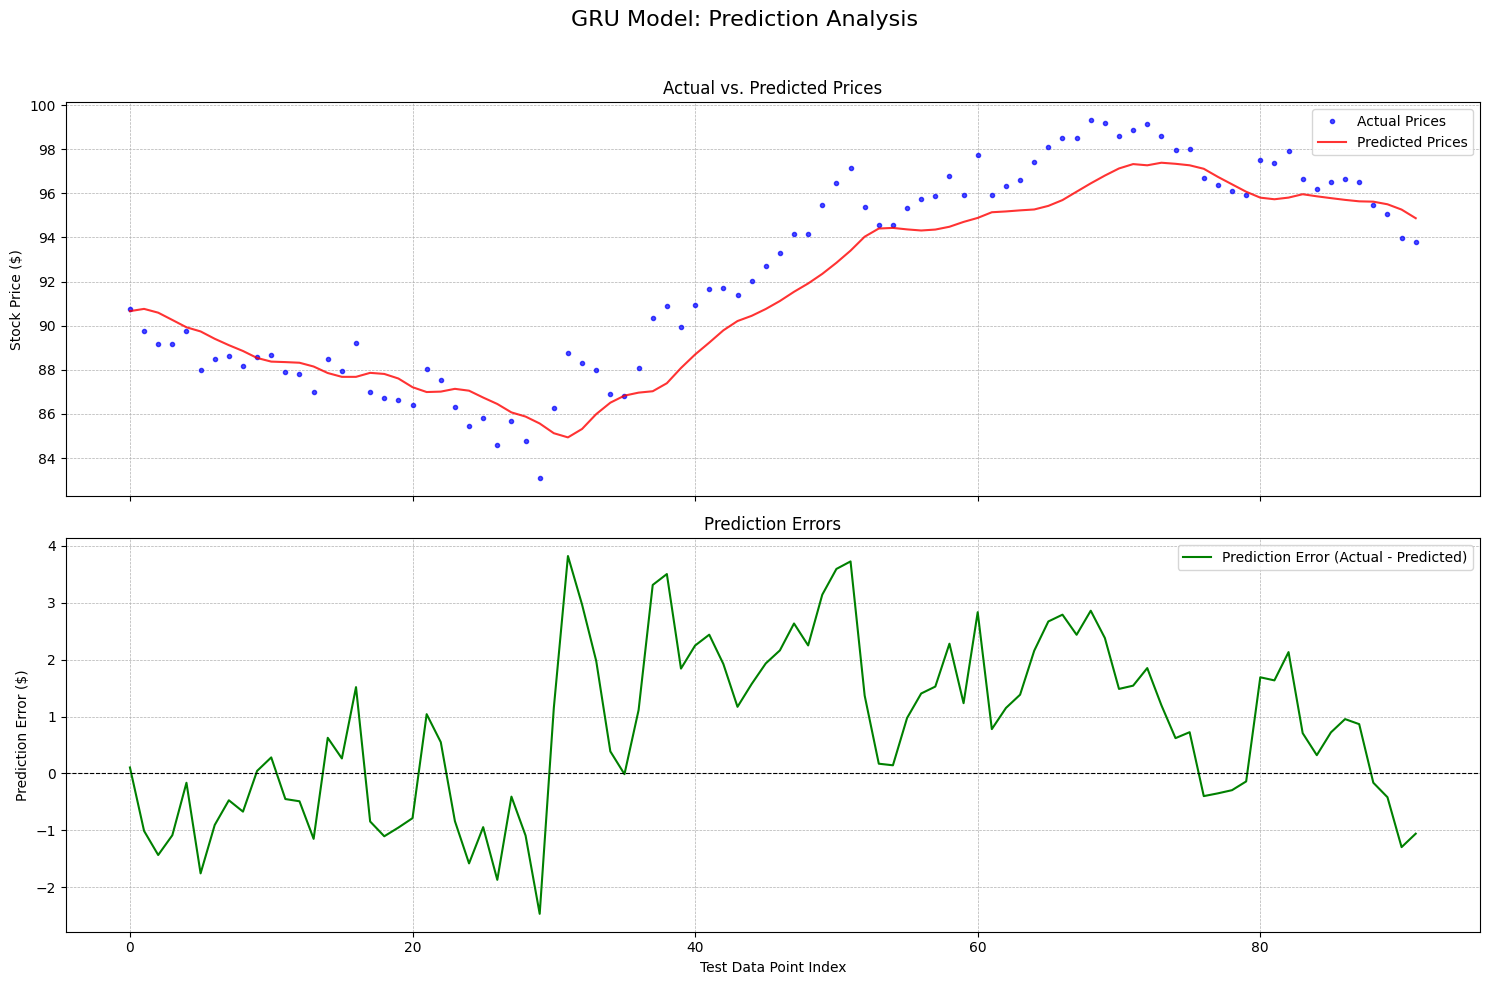


--- Prediction Highlights & Lowlights ---

✅ 5 Best Predictions (Lowest Absolute Error):
    Actual_Price  Predicted_Price  Error  Absolute_Error
35         86.82        86.830002  -0.01            0.01
9          88.58        88.540001   0.04            0.04
0          90.76        90.660004   0.10            0.10
54         94.57        94.430000   0.14            0.14
79         95.93        96.070000  -0.14            0.14

❌ 5 Worst Predictions (Highest Absolute Error):
    Actual_Price  Predicted_Price  Error  Absolute_Error
31         88.76        84.940002   3.82            3.82
51         97.13        93.400002   3.73            3.73
50         96.45        92.849998   3.60            3.60
38         90.90        87.389999   3.51            3.51
37         90.34        87.029999   3.31            3.31

--- Statistical Summary of Errors ---
count    92.0000
mean      0.8002
std       1.4781
min      -2.4720
25%      -0.4125
50%       0.8218
75%       1.9259
max       3.8237
Na

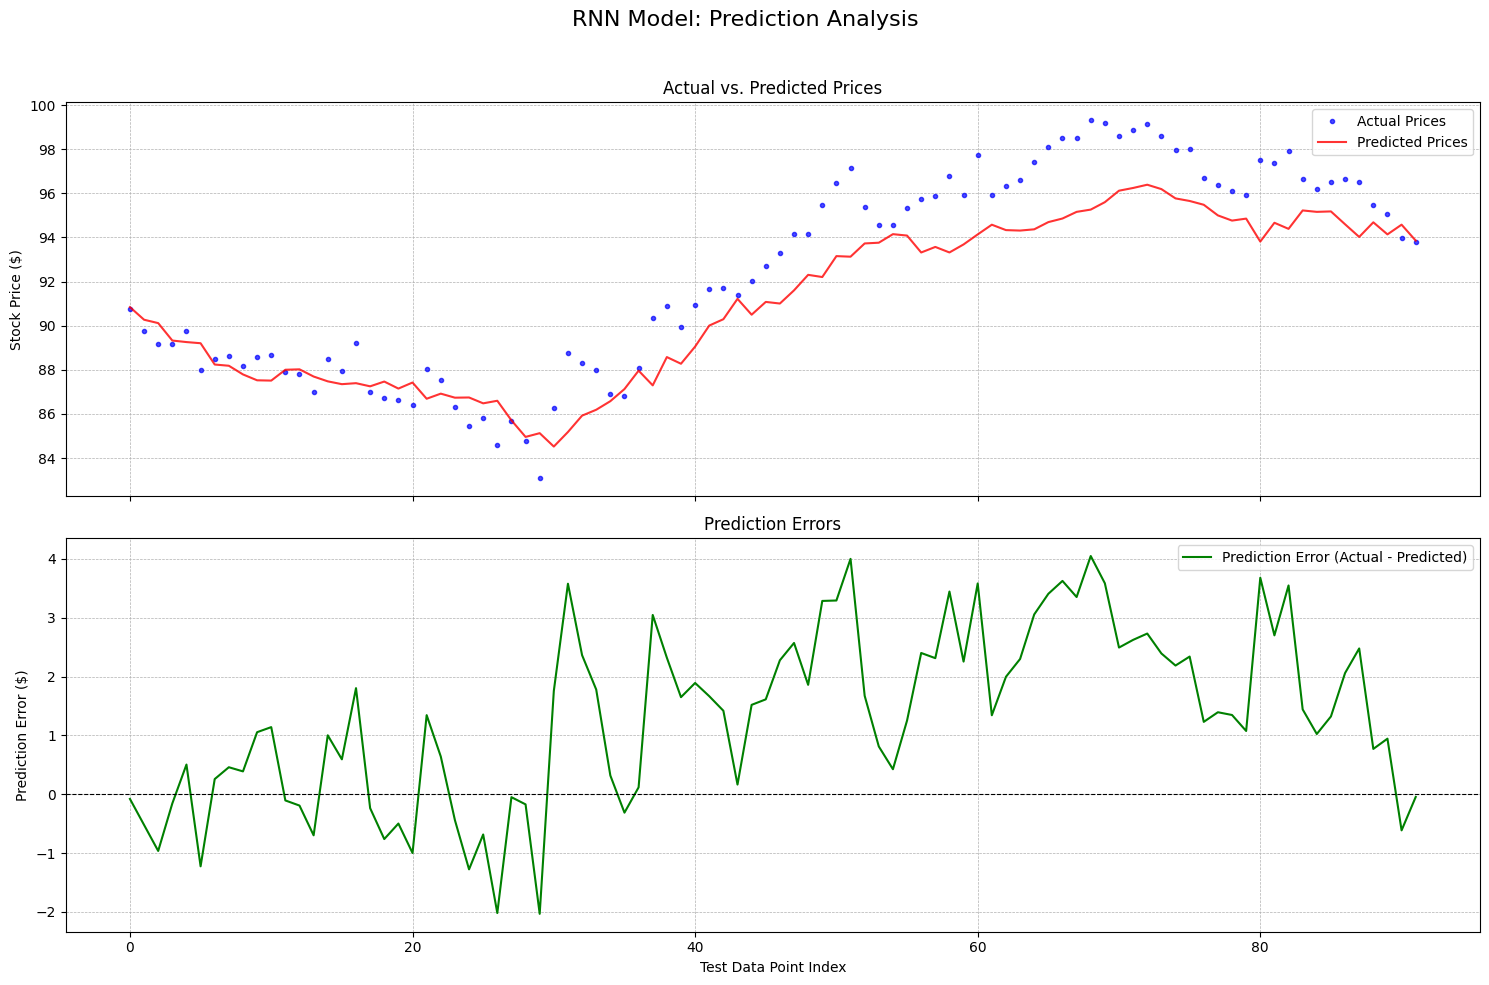


--- Prediction Highlights & Lowlights ---

✅ 5 Best Predictions (Lowest Absolute Error):
    Actual_Price  Predicted_Price  Error  Absolute_Error
91         93.81        93.860001  -0.05            0.05
27         85.66        85.709999  -0.05            0.05
0          90.76        90.839996  -0.08            0.08
11         87.90        88.000000  -0.11            0.11
36         88.08        87.959999   0.12            0.12

❌ 5 Worst Predictions (Highest Absolute Error):
    Actual_Price  Predicted_Price  Error  Absolute_Error
68         99.31        95.260002   4.05            4.05
51         97.13        93.129997   4.00            4.00
80         97.49        93.809998   3.68            3.68
66         98.48        94.860001   3.63            3.63
69         99.18        95.599998   3.59            3.59

--- Statistical Summary of Errors ---
count    92.0000
mean      1.3291
std       1.4713
min      -2.0333
25%       0.1524
50%       1.3706
75%       2.3718
max       4.0500
Na

In [16]:
import numpy as np
import os
import pickle
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from sklearn.metrics import mean_squared_error, mean_absolute_error

# --- Configuration ---
COMPANY = 'CBA.AX'
DATA_DIR = "data"
MODEL_DIR = "models"

# --- 1. Load the Trained Models ---
print("--- Loading Trained Models ---")
try:
    # Define model paths
    lstm_model_path = os.path.join(MODEL_DIR, f"{COMPANY}_lstm_model.keras")
    gru_model_path = os.path.join(MODEL_DIR, f"{COMPANY}_gru_model.keras")
    rnn_model_path = os.path.join(MODEL_DIR, f"{COMPANY}_rnn_model.keras")

    # Load the models
    lstm_model = load_model(lstm_model_path)
    gru_model = load_model(gru_model_path)
    rnn_model = load_model(rnn_model_path)
    
    print(f"✅ Successfully loaded 3 models: LSTM, GRU, and RNN.")
    models = {'LSTM': lstm_model, 'GRU': gru_model, 'RNN': rnn_model}

except Exception as e:
    print(f"❌ Error loading models: {e}")
    print("Please ensure that the training cells have been run and the .keras files are saved in the 'models' directory.")
    # Stop execution if models can't be loaded
    raise

# --- 2. Load the Scaler ---
# The scaler is needed to inverse transform the predictions back to actual prices.
print("\n--- Loading Data Scaler ---")
try:
    scalers_filename = f"{DATA_DIR}/{COMPANY}_scalers.pkl"
    with open(scalers_filename, 'rb') as f:
        scalers = pickle.load(f)
    # We specifically need the scaler for the 'Close' price, which was our target variable.
    close_scaler = scalers['Close']
    print("✅ Scaler for 'Close' price loaded successfully.")
except Exception as e:
    print(f"❌ Error loading scalers: {e}")
    print("The 'scalers.pkl' file is required to understand the model's output.")
    # Stop execution if scaler isn't found
    raise

# --- 3. Make Predictions on the Test Set ---
print("\n--- Making Predictions on Test Data ---")
predictions = {}
# Add a check for X_test existence
if 'X_test' not in locals():
    # Attempt to recreate X_test if it doesn't exist (e.g., running script in a new session)
    try:
        print("Variable 'X_test' not found. Attempting to recreate from saved data...")
        # This assumes 'test_data' and 'PREDICTION_DAYS' are available from previous cells
        test_values = scaled_test_data[['Close', 'High', 'Low', 'Volume']].values
        X_test, y_test = create_sequences(test_values, PREDICTION_DAYS)
        print("✅ 'X_test' and 'y_test' recreated.")
    except NameError:
         raise NameError("Critical variables ('X_test', 'test_data', 'PREDICTION_DAYS') not found. Please run the data preparation cells.")

for name, model in models.items():
    print(f" > Predicting with {name} model...")
    predictions[name] = model.predict(X_test)

print("✅ Predictions complete for all models.")

# --- 4. Inverse Transform Predictions and Actual Values ---
# The model predicts scaled values. We need to revert them to their original scale (dollars).
print("\n--- De-scaling Predictions for Comparison ---")

# De-scale the actual test values (y_test) for comparison
if 'y_test' not in locals():
    raise NameError("Variable 'y_test' not found. Please run the data preparation cell.")
actual_prices = close_scaler.inverse_transform(y_test.reshape(-1, 1))

# De-scale the predicted values from each model
descaled_predictions = {}
for name, pred in predictions.items():
    descaled_predictions[name] = close_scaler.inverse_transform(pred)
    print(f"✅ De-scaled {name} predictions.")

# --- 5. Calculate and Display Overall Prediction Metrics ---
print("\n--- Overall Prediction Performance Metrics ---")
metrics = []
for name, pred_prices in descaled_predictions.items():
    mae = mean_absolute_error(actual_prices, pred_prices)
    mse = mean_squared_error(actual_prices, pred_prices)
    rmse = np.sqrt(mse)
    metrics.append({'Model': name, 'MAE ($)': mae, 'MSE': mse, 'RMSE ($)': rmse})

metrics_df = pd.DataFrame(metrics)
metrics_df.set_index('Model', inplace=True)

print(metrics_df.round(4))
print("=============================================\n")


# --- 6. Detailed Analysis for Each Model ---
for name, pred_prices in descaled_predictions.items():
    print(f"\n\n--- Detailed Analysis for {name} Model ---")
    print("=================================================")
    
    # Create a results DataFrame for the current model
    results_df = pd.DataFrame({
        'Actual_Price': actual_prices.flatten(),
        'Predicted_Price': pred_prices.flatten()
    })
    results_df['Error'] = results_df['Actual_Price'] - results_df['Predicted_Price']
    results_df['Absolute_Error'] = np.abs(results_df['Error'])
    
    # a. Save predictions to CSV
    predictions_filename = os.path.join(DATA_DIR, f"{COMPANY}_predictions_{name}.csv")
    results_df.to_csv(predictions_filename, index=False)
    print(f"✅ Predictions for {name} model saved to: {predictions_filename}")

    # b. Visualize predictions vs actual and c. Plot prediction errors
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10), sharex=True)
    fig.suptitle(f'{name} Model: Prediction Analysis', fontsize=16)

    # Plotting actual vs predicted
    ax1.plot(results_df.index, results_df['Actual_Price'], label='Actual Prices', color='blue', marker='.', linestyle='', alpha=0.7)
    ax1.plot(results_df.index, results_df['Predicted_Price'], label='Predicted Prices', color='red', linestyle='-', alpha=0.8)
    ax1.set_ylabel('Stock Price ($)')
    ax1.set_title('Actual vs. Predicted Prices')
    ax1.legend()
    ax1.grid(True, which='both', linestyle='--', linewidth=0.5)

    # Plotting prediction errors
    ax2.plot(results_df.index, results_df['Error'], label='Prediction Error (Actual - Predicted)', color='green', linestyle='-')
    ax2.axhline(y=0, color='black', linestyle='--', linewidth=0.8)
    ax2.set_xlabel('Test Data Point Index')
    ax2.set_ylabel('Prediction Error ($)')
    ax2.set_title('Prediction Errors')
    ax2.legend()
    ax2.grid(True, which='both', linestyle='--', linewidth=0.5)
    
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

    # d. Additional analysis: Best and worst predictions
    print("\n--- Prediction Highlights & Lowlights ---")
    best_predictions = results_df.nsmallest(5, 'Absolute_Error')
    worst_predictions = results_df.nlargest(5, 'Absolute_Error')
    
    print("\n✅ 5 Best Predictions (Lowest Absolute Error):")
    print(best_predictions.round(2))
    
    print("\n❌ 5 Worst Predictions (Highest Absolute Error):")
    print(worst_predictions.round(2))

    # e. Statistical summary of errors
    print("\n--- Statistical Summary of Errors ---")
    print(results_df['Error'].describe().round(4))
    print("----------------------------------------")



--- Interactive Candlestick Visualization ---
Select a model to visualize:
1: LSTM
2: GRU
3: RNN
q: Quit
INFO: 'Open' column not found. Deriving it from previous day's 'Close'.


C:\Users\Admin\AppData\Local\Temp\ipykernel_19668\3050163749.py:166: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  plot_df['Open'].fillna(plot_df['Close'], inplace=True)
C:\Users\Admin\AppData\Local\Temp\ipykernel_19668\3050163749.py:107: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 1, 0.96]) # Adjust layout to make room for suptitle


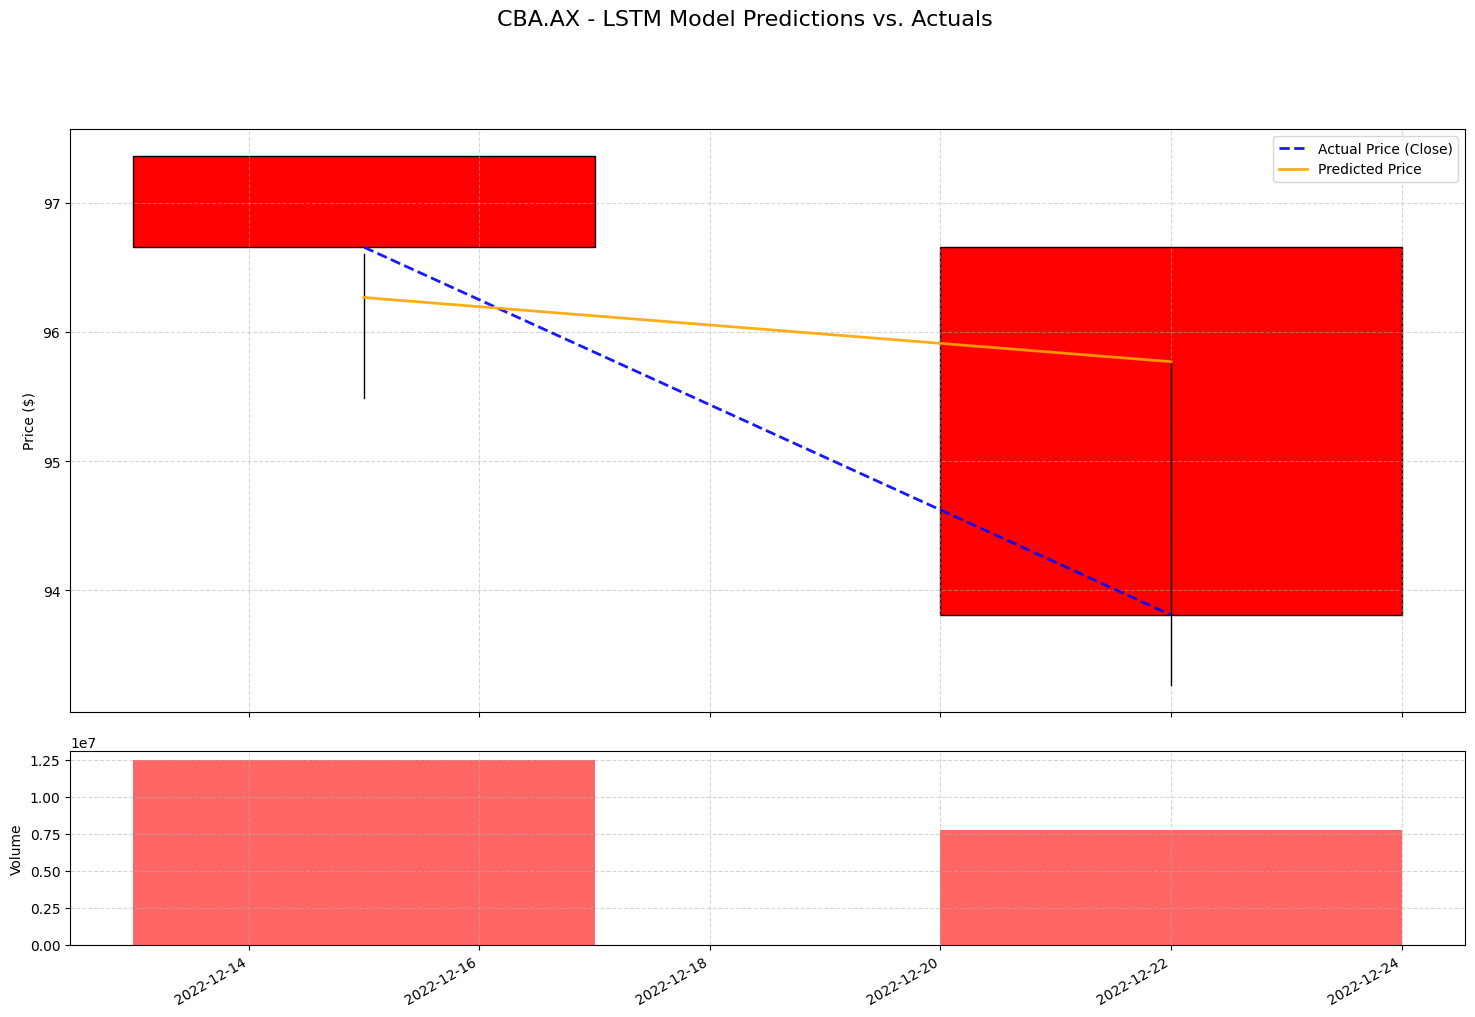



--- Interactive Candlestick Visualization ---
Select a model to visualize:
1: LSTM
2: GRU
3: RNN
q: Quit
INFO: 'Open' column not found. Deriving it from previous day's 'Close'.


C:\Users\Admin\AppData\Local\Temp\ipykernel_19668\3050163749.py:166: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  plot_df['Open'].fillna(plot_df['Close'], inplace=True)
C:\Users\Admin\AppData\Local\Temp\ipykernel_19668\3050163749.py:107: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 1, 0.96]) # Adjust layout to make room for suptitle


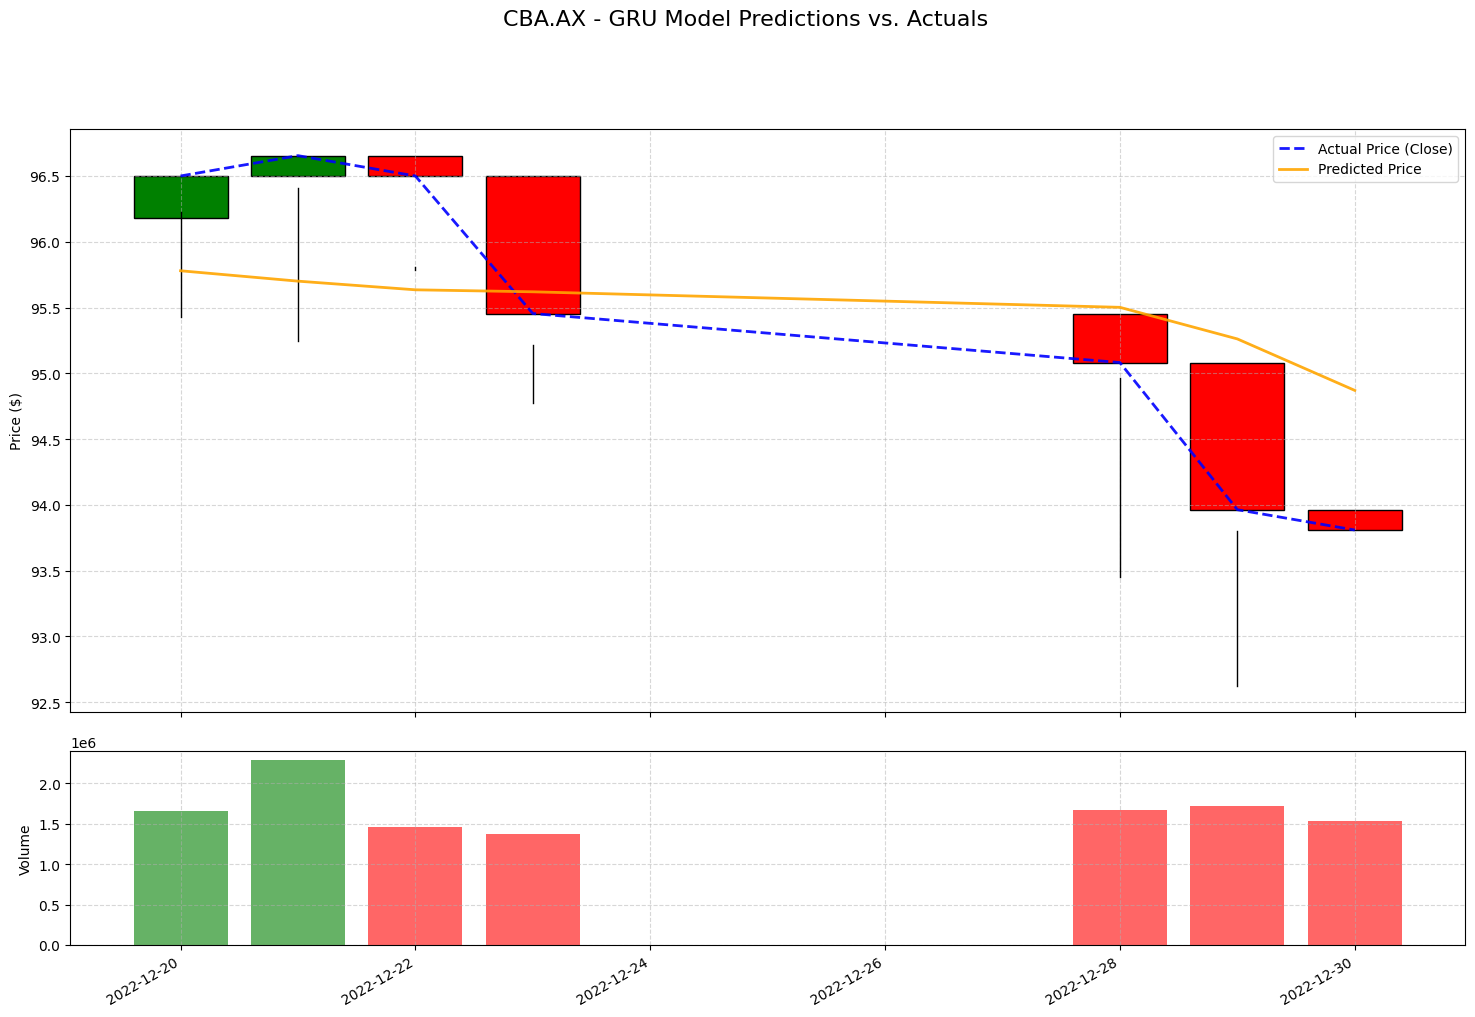



--- Interactive Candlestick Visualization ---
Select a model to visualize:
1: LSTM
2: GRU
3: RNN
q: Quit
INFO: 'Open' column not found. Deriving it from previous day's 'Close'.


C:\Users\Admin\AppData\Local\Temp\ipykernel_19668\3050163749.py:166: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  plot_df['Open'].fillna(plot_df['Close'], inplace=True)
C:\Users\Admin\AppData\Local\Temp\ipykernel_19668\3050163749.py:107: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 1, 0.96]) # Adjust layout to make room for suptitle


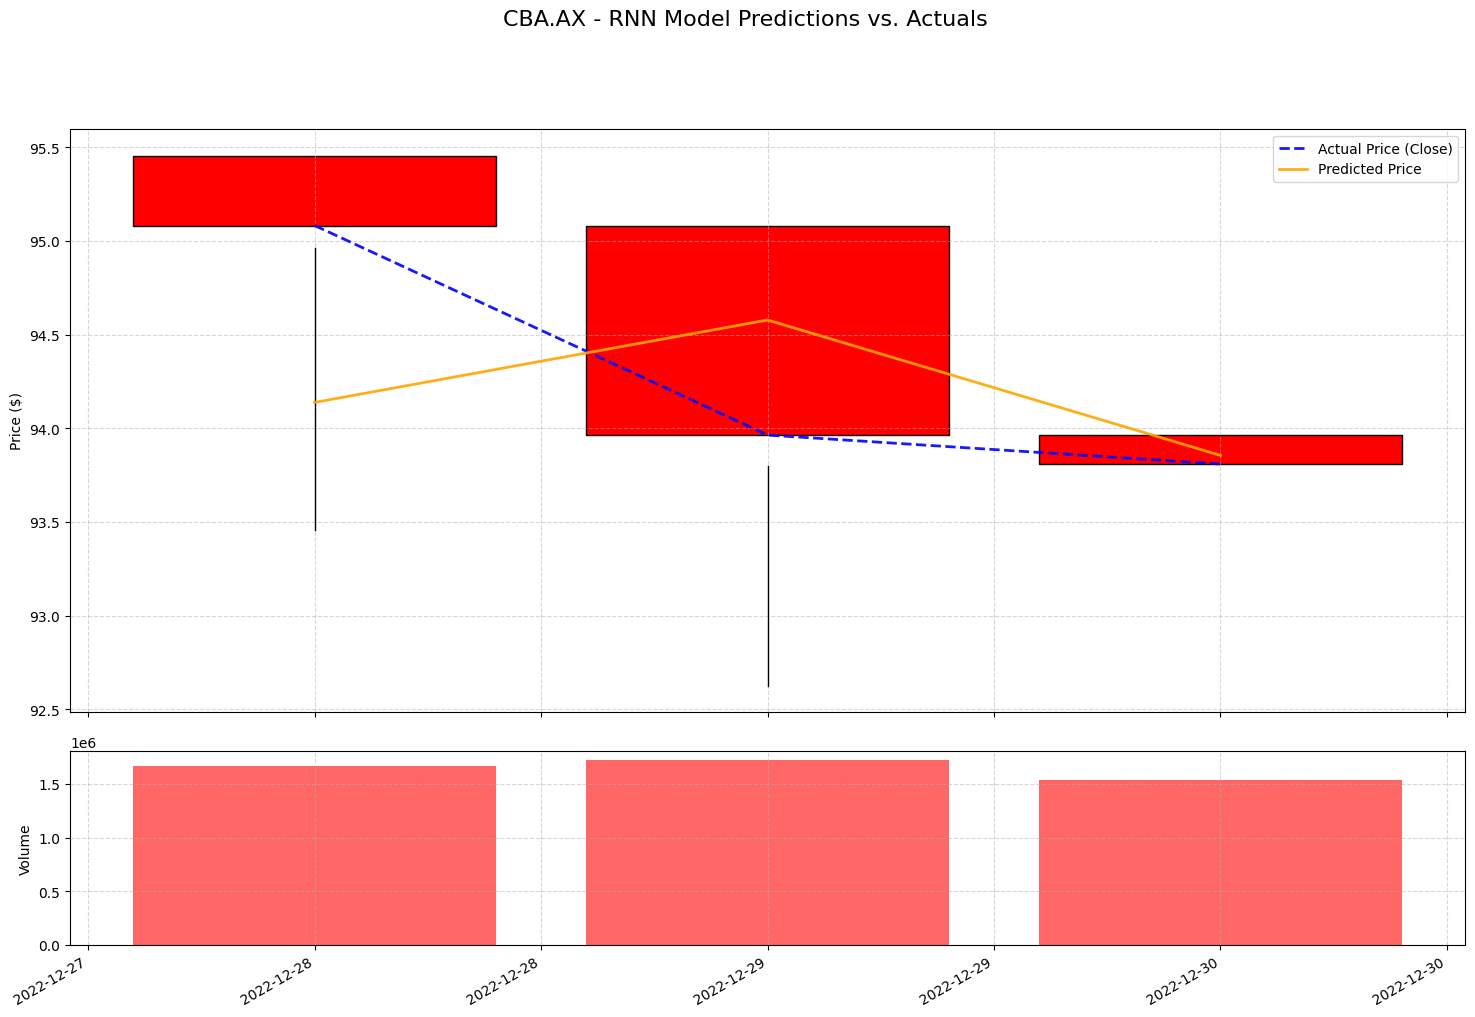



--- Interactive Candlestick Visualization ---
Select a model to visualize:
1: LSTM
2: GRU
3: RNN
q: Quit
Exiting interactive visualization.


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.patches import Rectangle

# --- Helper function to aggregate daily data into N-day candlesticks ---
def create_candlestick_data(df, n_days=1):
    """
    Aggregates a DataFrame of daily stock data into multi-day candlesticks.
    
    Args:
        df (pd.DataFrame): DataFrame containing daily OHLCV and prediction data.
                           Must include 'Date', 'Open', 'High', 'Low', 'Close', 'Volume',
                           'Actual_Price', and 'Predicted_Price'.
        n_days (int): The number of trading days to aggregate into one candlestick.

    Returns:
        pd.DataFrame: A new DataFrame with the aggregated candlestick data.
    """
    # Ensure 'Date' is a column and in datetime format for proper grouping
    if 'Date' not in df.columns:
        df = df.reset_index()
    df['Date'] = pd.to_datetime(df['Date'])

    if n_days == 1:
        return df

    # Aggregate data into N-day groups
    # The `//` operator performs integer division to create groups of `n_days` size
    grouped = df.groupby(np.arange(len(df)) // n_days).agg(
        Date=('Date', 'first'),          # Start date of the period
        Open=('Open', 'first'),          # Opening price of the period
        High=('High', 'max'),            # Max high during the period
        Low=('Low', 'min'),              # Min low during the period
        Close=('Close', 'last'),         # Closing price of the period
        Volume=('Volume', 'sum'),        # Sum of volume over the period
        # Use the last value for predictions as it represents the period's end
        Actual_Price=('Actual_Price', 'last'),
        Predicted_Price=('Predicted_Price', 'last'),
    )
    return grouped

# --- Main plotting function ---
def plot_prediction_candlesticks(df, title, n_days, limit_days):
    """
    Creates a candlestick chart from stock data and overlays model predictions.

    Args:
        df (pd.DataFrame): The DataFrame containing the data to plot.
        title (str): The title for the chart.
        n_days (int): The number of trading days per candlestick.
        limit_days (int): The number of recent data points (candlesticks) to display.
    """
    
    plot_data = df.copy()
    if limit_days:
        plot_data = plot_data.tail(limit_days)
    
    # Aggregate data into N-day candlesticks if needed
    plot_data = create_candlestick_data(plot_data, n_days=n_days)
    
    if plot_data.empty:
        print("No data available to plot for the given parameters.")
        return

    # Create subplots for price and volume
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(18, 12), sharex=True, 
                                   height_ratios=[3, 1], gridspec_kw={'hspace': 0.1})
    fig.suptitle(title, fontsize=16)

    # Convert dates to matplotlib's internal float format for plotting
    plot_data['Date_Num'] = mdates.date2num(pd.to_datetime(plot_data['Date']))
    
    # Dynamically set width of candlesticks based on aggregation
    width = 0.8 * n_days

    # --- Plot Candlesticks and Predictions on the top subplot (ax1) ---
    for index, row in plot_data.iterrows():
        color = 'green' if row['Close'] >= row['Open'] else 'red'
        # Plot the wicks (high-low lines)
        ax1.plot([row['Date_Num'], row['Date_Num']], [row['Low'], row['High']], color='black', linewidth=1)
        # Create the candlestick body
        body = Rectangle((row['Date_Num'] - width/2, min(row['Open'], row['Close'])), width, abs(row['Close'] - row['Open']), facecolor=color, edgecolor='black')
        ax1.add_patch(body)

    # Overlay Actual and Predicted Prices
    ax1.plot(plot_data['Date_Num'], plot_data['Actual_Price'], label='Actual Price (Close)', color='blue', linestyle='--', alpha=0.9, linewidth=2)
    ax1.plot(plot_data['Date_Num'], plot_data['Predicted_Price'], label='Predicted Price', color='orange', linestyle='-', alpha=0.9, linewidth=2)
    
    # --- Plot Volume on the bottom subplot (ax2) ---
    volume_colors = ['green' if row['Close'] >= row['Open'] else 'red' for index, row in plot_data.iterrows()]
    ax2.bar(plot_data['Date_Num'], plot_data['Volume'], width=width, color=volume_colors, alpha=0.6)

    # --- Formatting and Labels ---
    ax1.set_ylabel('Price ($)')
    ax1.legend()
    ax1.grid(True, linestyle='--', alpha=0.5)
    
    ax2.set_ylabel('Volume')
    ax2.grid(True, linestyle='--', alpha=0.5)
    
    # Use matplotlib's date formatter for the x-axis
    ax2.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    fig.autofmt_xdate() # Auto-rotate date labels for better visibility

    plt.tight_layout(rect=[0, 0, 1, 0.96]) # Adjust layout to make room for suptitle
    plt.show()

# --- Interactive Loop to Select Model and Parameters ---
while True:
    print("\n\n--- Interactive Candlestick Visualization ---")
    print("Select a model to visualize:")
    print("1: LSTM")
    print("2: GRU")
    print("3: RNN")
    print("q: Quit")

    choice = input("Enter your choice (1/2/3/q): ").strip().lower()

    if choice == 'q':
        print("Exiting interactive visualization.")
        break
    
    if choice not in ['1', '2', '3']:
        print("❌ Invalid choice. Please try again.")
        continue

    model_map = {'1': 'LSTM', '2': 'GRU', '3': 'RNN'}
    model_name = model_map[choice]

    # Get user input for chart parameters
    try:
        n_days_input = input("Enter number of days per candlestick (e.g., 1 for daily, 5 for weekly) [default: 1]: ").strip()
        n_days = int(n_days_input) if n_days_input else 1
        
        limit_days_input = input("Enter number of recent days to display (e.g., 90) [default: 90]: ").strip()
        limit_days = int(limit_days_input) if limit_days_input else 90
    except ValueError:
        print("❌ Invalid number. Using defaults (1 day per candle, 90 days limit).")
        n_days = 1
        limit_days = 90
    
    # --- Prepare the data for plotting ---
    try:
        # The predictions align with the test set, starting from PREDICTION_DAYS into the test_data
        if 'test_data' not in locals():
             raise NameError("'test_data' DataFrame not found. Please ensure the data splitting cell was run.")
        
        # Check if we have enough data in test_data to offset
        if len(test_data) <= PREDICTION_DAYS:
            raise ValueError(f"Not enough data in 'test_data' to create visualization. 'test_data' has {len(test_data)} rows, but requires at least {PREDICTION_DAYS + 1} for lookback.")

        # Create the dataframe for plotting by taking the relevant slice of the test data
        # and adding the actual and predicted prices as new columns.
        plot_df = test_data.iloc[PREDICTION_DAYS:].copy()
        plot_df['Actual_Price'] = actual_prices.flatten()
        plot_df['Predicted_Price'] = descaled_predictions[model_name].flatten()
        
        # --- FIX: Ensure 'Open' column exists for candlestick chart ---
        if 'Open' not in plot_df.columns:
            print("INFO: 'Open' column not found. Deriving it from previous day's 'Close'.")
            # Use previous day's close as the open price
            plot_df['Open'] = plot_df['Close'].shift(1)
            # For the first row, which will be NaN, use the 'Close' price of that day
            plot_df['Open'].fillna(plot_df['Close'], inplace=True)

        chart_title = f"{COMPANY} - {model_name} Model Predictions vs. Actuals"
        
        # Call the plotting function
        plot_prediction_candlesticks(df=plot_df, title=chart_title, n_days=n_days, limit_days=limit_days)

    except (NameError, ValueError) as e:
        print(f"❌ Error preparing data for plot: {e}")
        print("Please make sure the prerequisite cells for data preparation and model prediction have been run successfully.")



--- Boxplot Analysis Menu ---
Select the type of analysis:
1: Historical Data Analysis
2: Prediction Error Analysis
q: Quit

Select a period for historical analysis:
1: Monthly
2: Quarterly
3: Yearly
4: Weekly


C:\Users\Admin\AppData\Local\Temp\ipykernel_19668\2258369454.py:56: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(ax=axes[0, 0], data=boxplot_data, x='Period', y='Close', palette='viridis')
C:\Users\Admin\AppData\Local\Temp\ipykernel_19668\2258369454.py:61: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(ax=axes[0, 1], data=boxplot_data, x='Period', y='Price_Range', palette='plasma')
C:\Users\Admin\AppData\Local\Temp\ipykernel_19668\2258369454.py:66: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(ax=axes[1, 0], data=boxplot_data, x='Period', y=

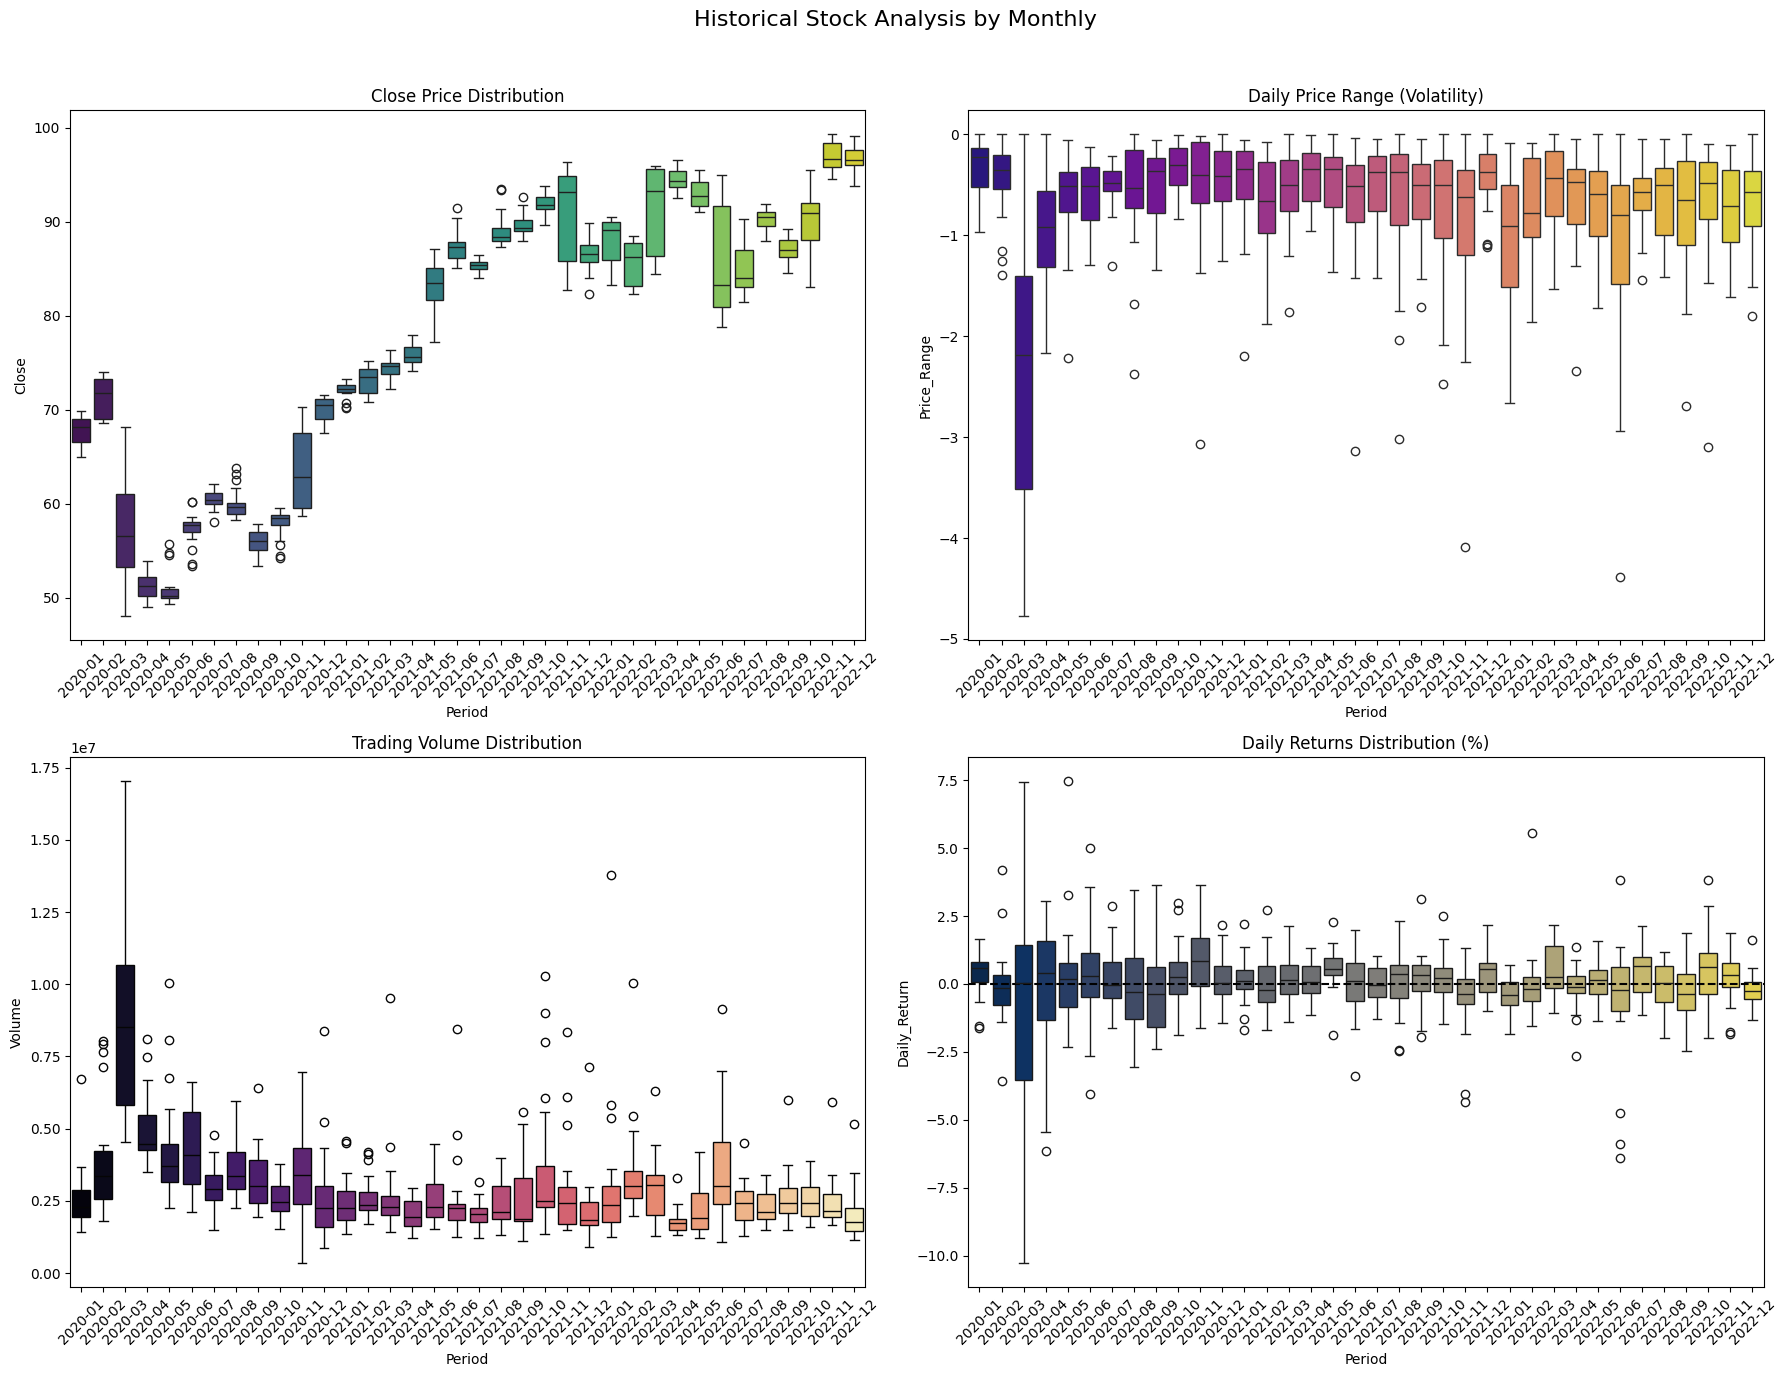



--- Boxplot Analysis Menu ---
Select the type of analysis:
1: Historical Data Analysis
2: Prediction Error Analysis
q: Quit

Select a model to analyze:
1: LSTM
2: GRU
3: RNN


C:\Users\Admin\AppData\Local\Temp\ipykernel_19668\2258369454.py:95: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(ax=ax1, y=results_df['Error'], palette='coolwarm')
C:\Users\Admin\AppData\Local\Temp\ipykernel_19668\2258369454.py:101: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(ax=ax2, y=results_df['Absolute_Error'], palette='spring')


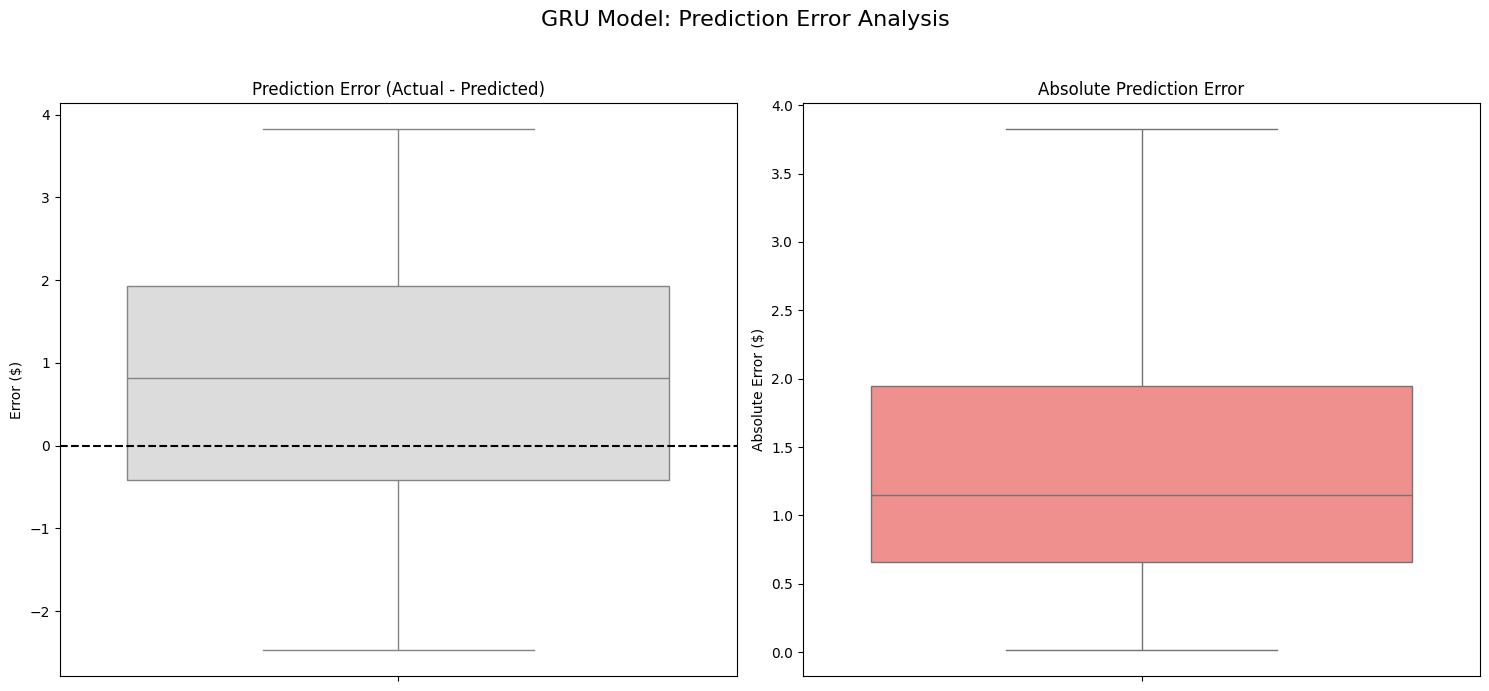



--- Boxplot Analysis Menu ---
Select the type of analysis:
1: Historical Data Analysis
2: Prediction Error Analysis
q: Quit

Select a period for historical analysis:
1: Monthly
2: Quarterly
3: Yearly
4: Weekly


C:\Users\Admin\AppData\Local\Temp\ipykernel_19668\2258369454.py:56: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(ax=axes[0, 0], data=boxplot_data, x='Period', y='Close', palette='viridis')
C:\Users\Admin\AppData\Local\Temp\ipykernel_19668\2258369454.py:61: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(ax=axes[0, 1], data=boxplot_data, x='Period', y='Price_Range', palette='plasma')
C:\Users\Admin\AppData\Local\Temp\ipykernel_19668\2258369454.py:66: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(ax=axes[1, 0], data=boxplot_data, x='Period', y=

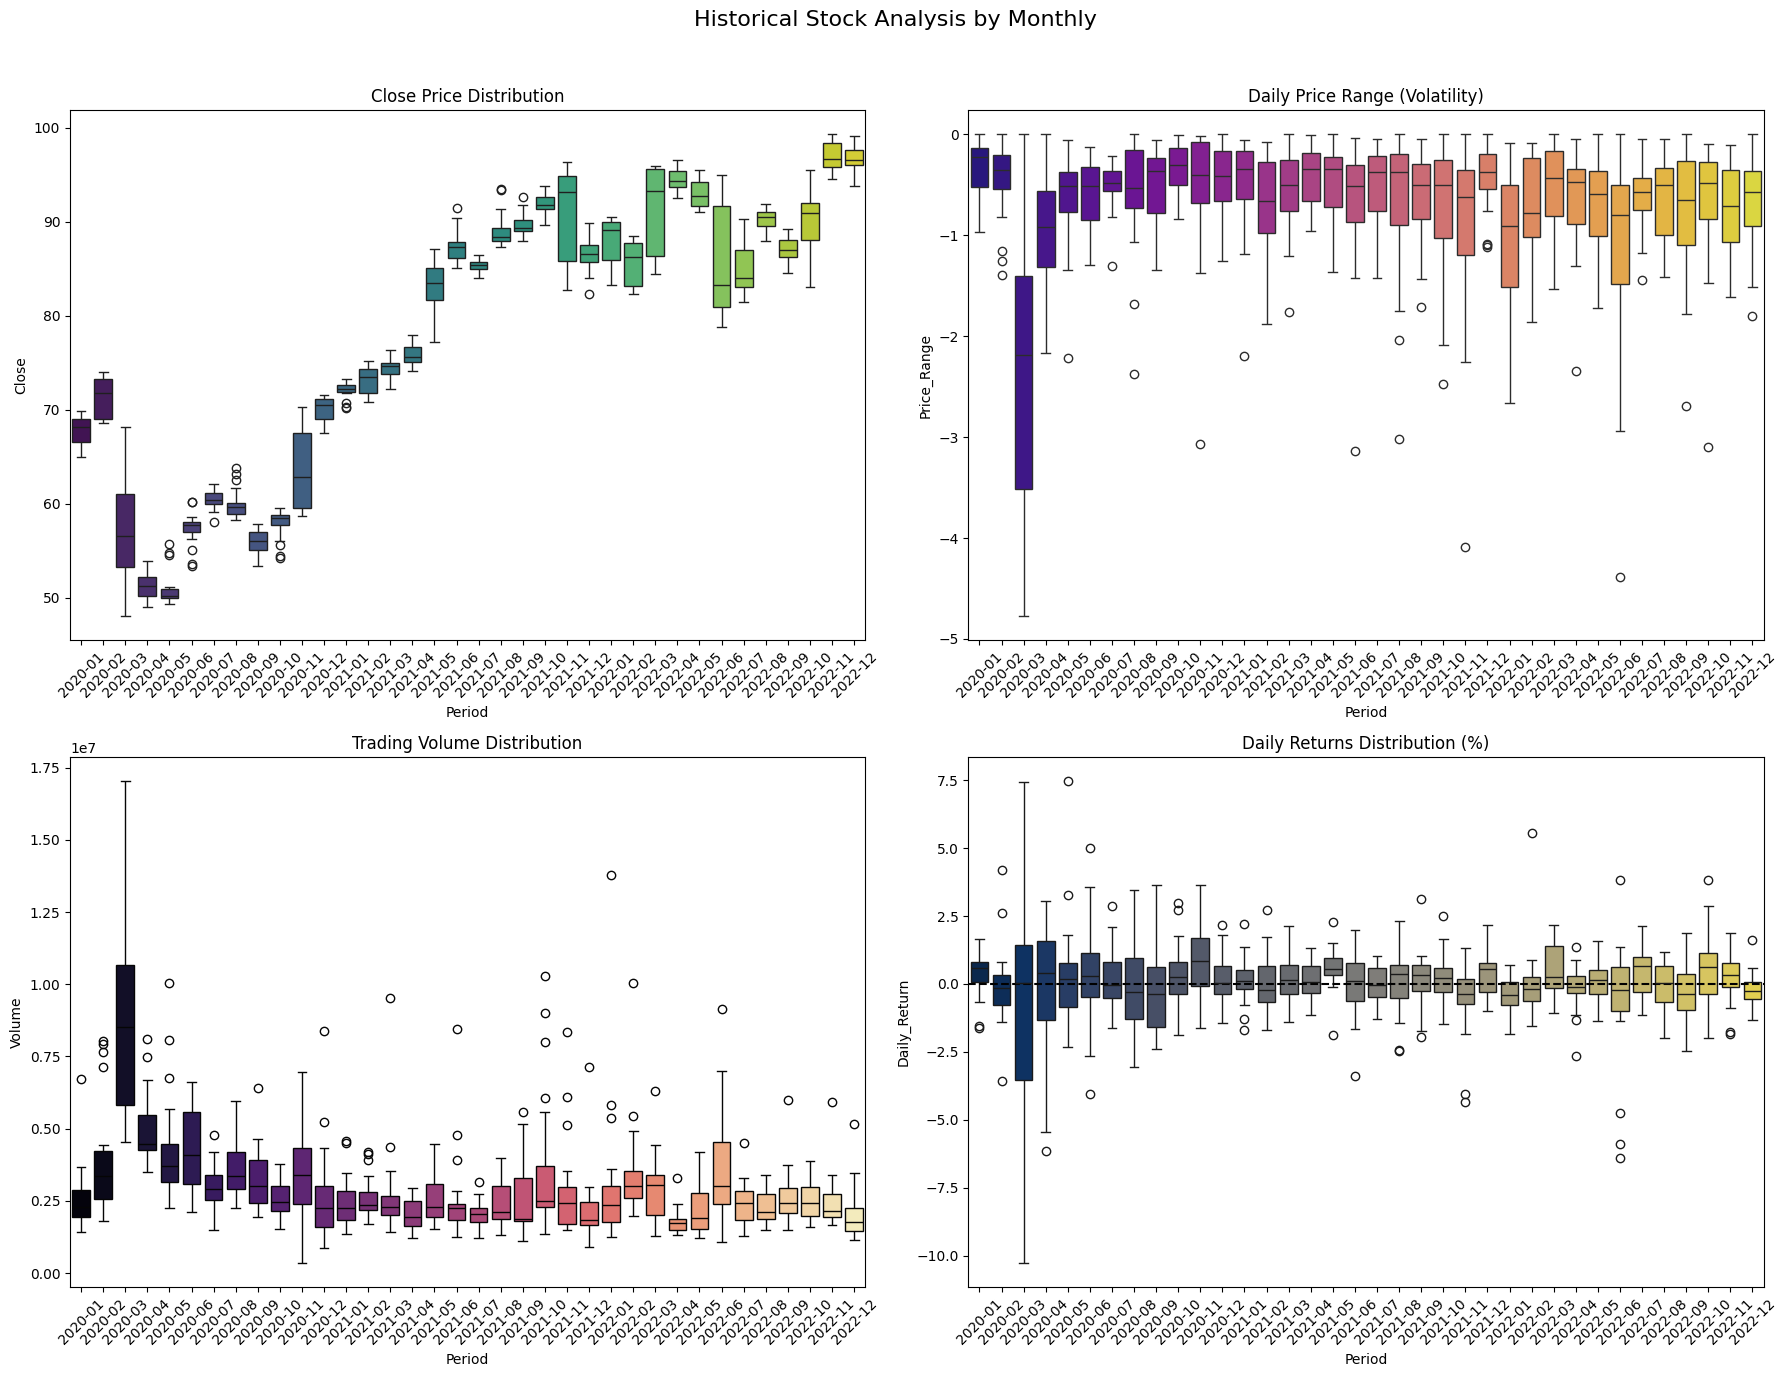



--- Boxplot Analysis Menu ---
Select the type of analysis:
1: Historical Data Analysis
2: Prediction Error Analysis
q: Quit

Select a period for historical analysis:
1: Monthly
2: Quarterly
3: Yearly
4: Weekly


C:\Users\Admin\AppData\Local\Temp\ipykernel_19668\2258369454.py:56: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(ax=axes[0, 0], data=boxplot_data, x='Period', y='Close', palette='viridis')
C:\Users\Admin\AppData\Local\Temp\ipykernel_19668\2258369454.py:61: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(ax=axes[0, 1], data=boxplot_data, x='Period', y='Price_Range', palette='plasma')
C:\Users\Admin\AppData\Local\Temp\ipykernel_19668\2258369454.py:66: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(ax=axes[1, 0], data=boxplot_data, x='Period', y=

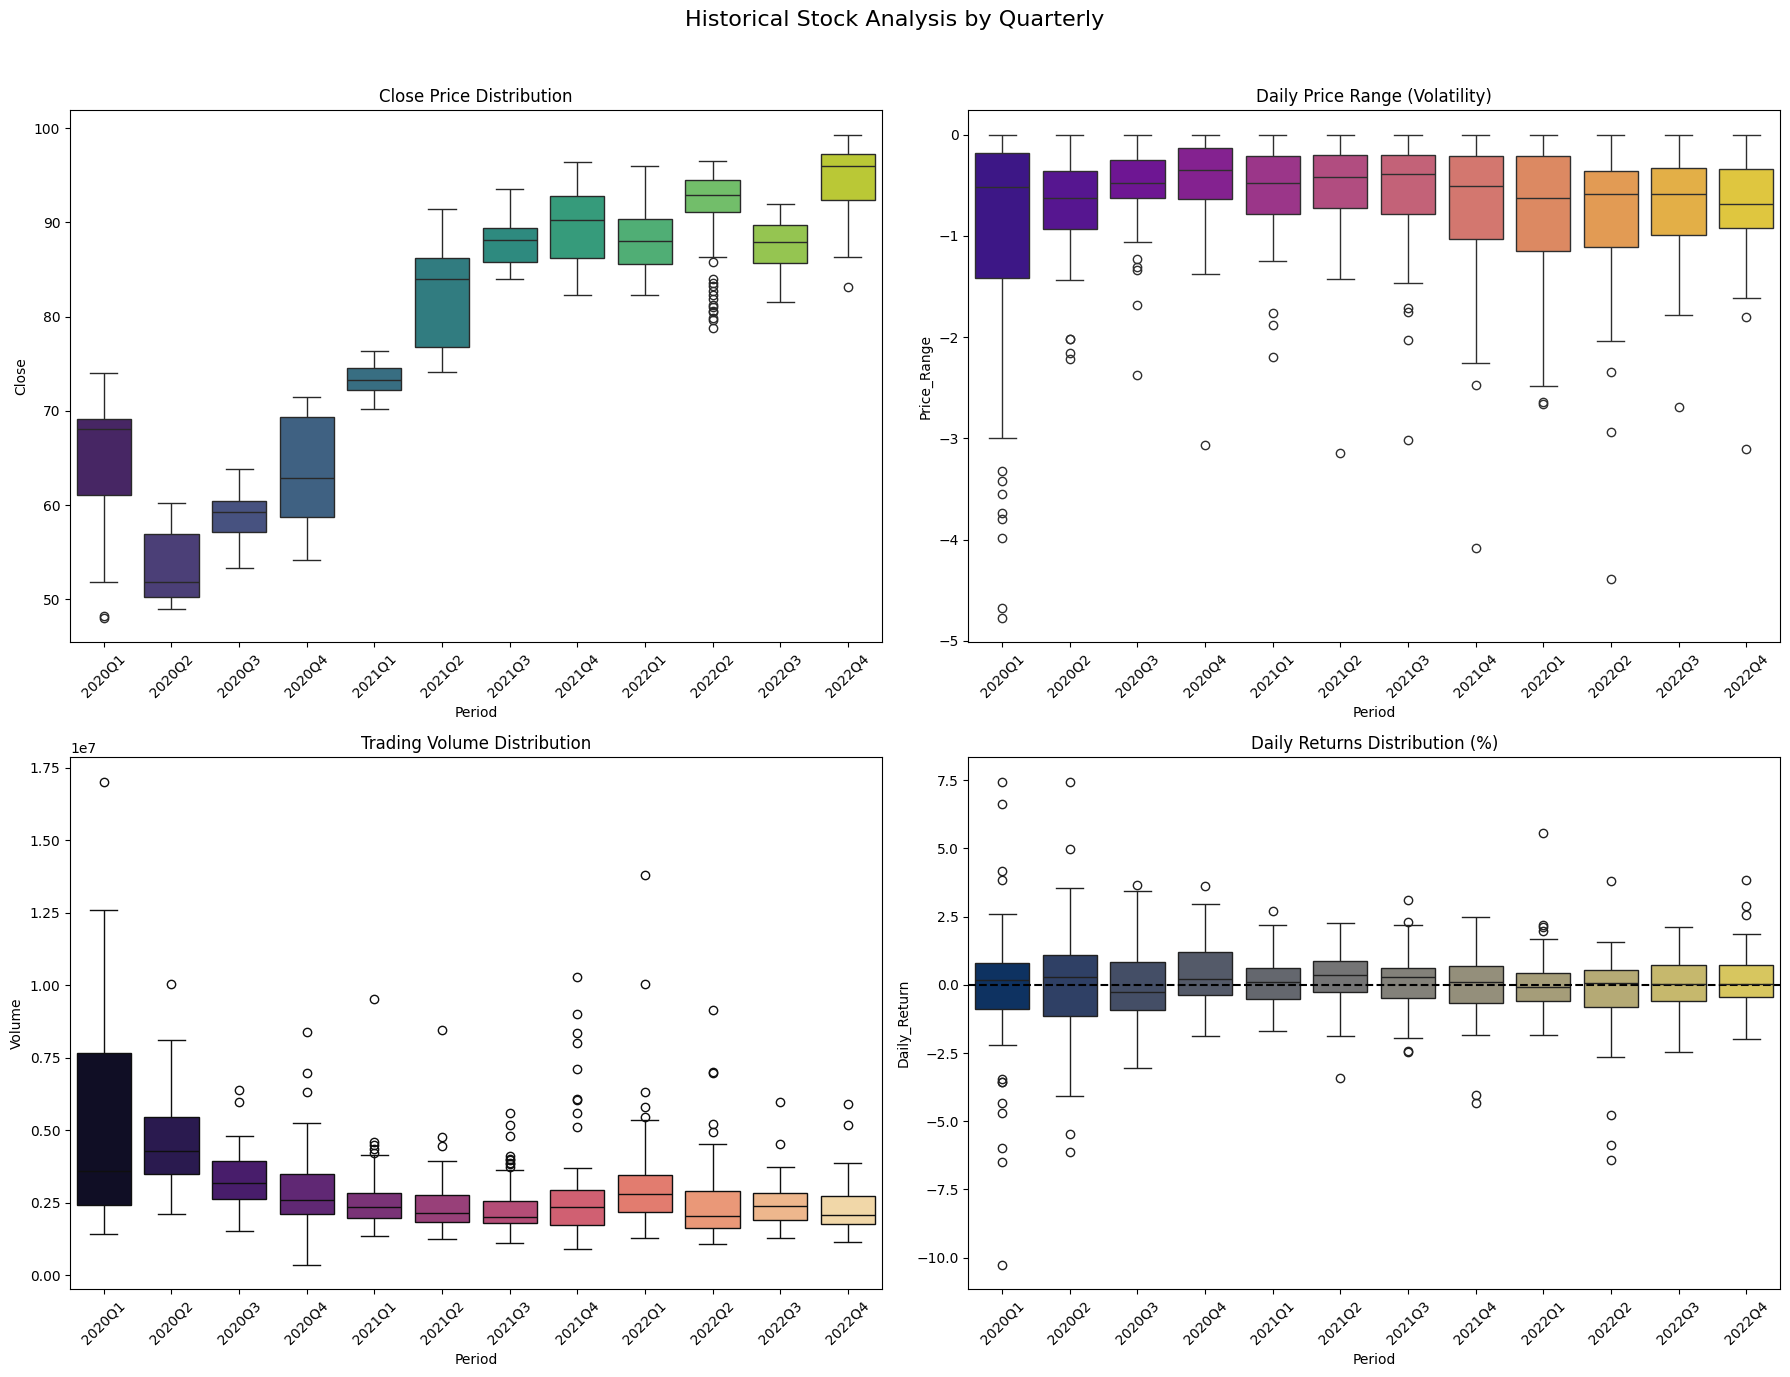



--- Boxplot Analysis Menu ---
Select the type of analysis:
1: Historical Data Analysis
2: Prediction Error Analysis
q: Quit

Select a period for historical analysis:
1: Monthly
2: Quarterly
3: Yearly
4: Weekly


C:\Users\Admin\AppData\Local\Temp\ipykernel_19668\2258369454.py:56: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(ax=axes[0, 0], data=boxplot_data, x='Period', y='Close', palette='viridis')
C:\Users\Admin\AppData\Local\Temp\ipykernel_19668\2258369454.py:61: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(ax=axes[0, 1], data=boxplot_data, x='Period', y='Price_Range', palette='plasma')
C:\Users\Admin\AppData\Local\Temp\ipykernel_19668\2258369454.py:66: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(ax=axes[1, 0], data=boxplot_data, x='Period', y=

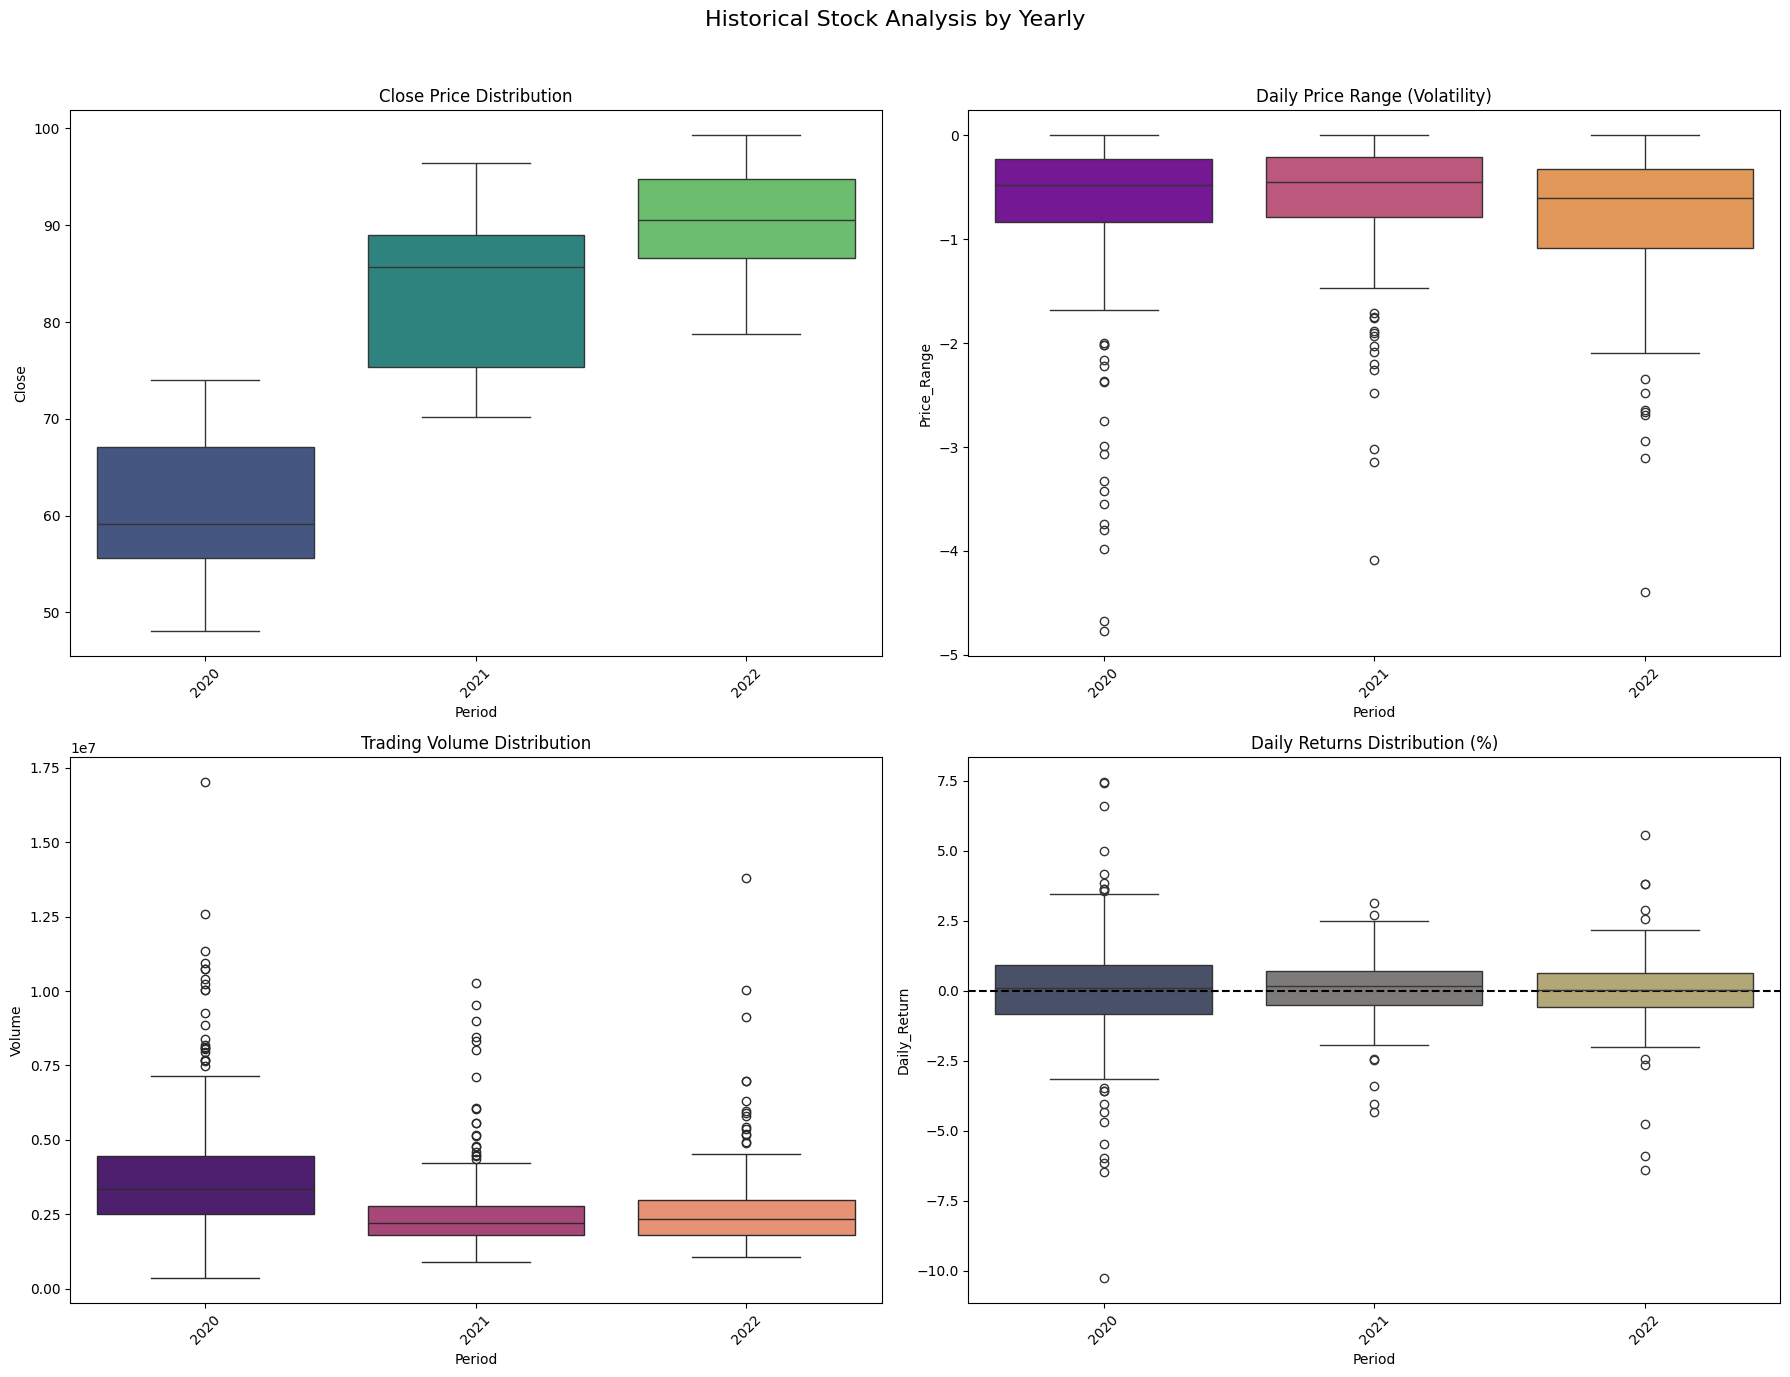



--- Boxplot Analysis Menu ---
Select the type of analysis:
1: Historical Data Analysis
2: Prediction Error Analysis
q: Quit

Select a period for historical analysis:
1: Monthly
2: Quarterly
3: Yearly
4: Weekly


C:\Users\Admin\AppData\Local\Temp\ipykernel_19668\2258369454.py:56: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(ax=axes[0, 0], data=boxplot_data, x='Period', y='Close', palette='viridis')
C:\Users\Admin\AppData\Local\Temp\ipykernel_19668\2258369454.py:61: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(ax=axes[0, 1], data=boxplot_data, x='Period', y='Price_Range', palette='plasma')
C:\Users\Admin\AppData\Local\Temp\ipykernel_19668\2258369454.py:66: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(ax=axes[1, 0], data=boxplot_data, x='Period', y=

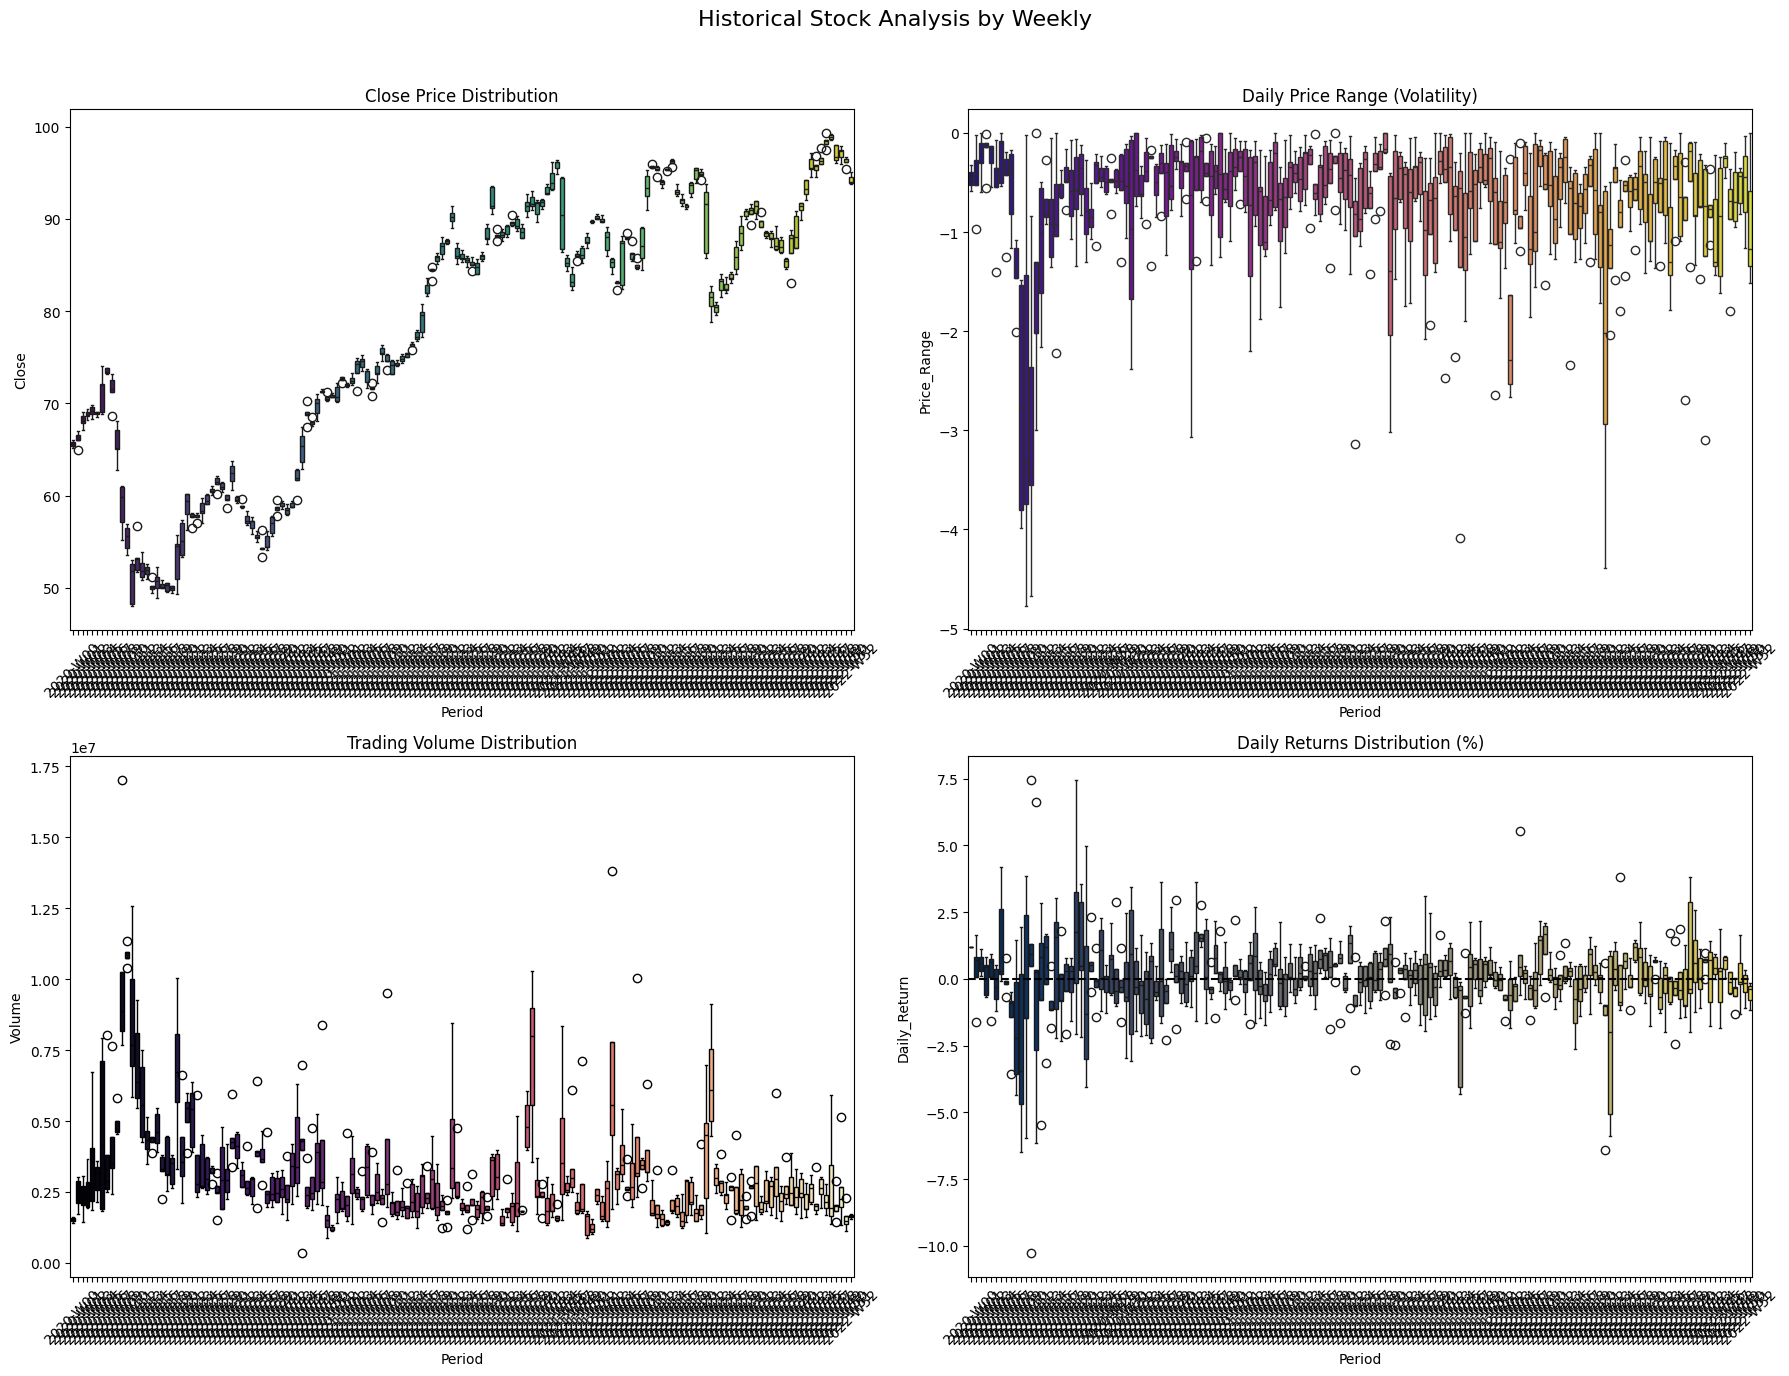



--- Boxplot Analysis Menu ---
Select the type of analysis:
1: Historical Data Analysis
2: Prediction Error Analysis
q: Quit

Select a model to analyze:
1: LSTM
2: GRU
3: RNN


C:\Users\Admin\AppData\Local\Temp\ipykernel_19668\2258369454.py:95: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(ax=ax1, y=results_df['Error'], palette='coolwarm')
C:\Users\Admin\AppData\Local\Temp\ipykernel_19668\2258369454.py:101: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(ax=ax2, y=results_df['Absolute_Error'], palette='spring')


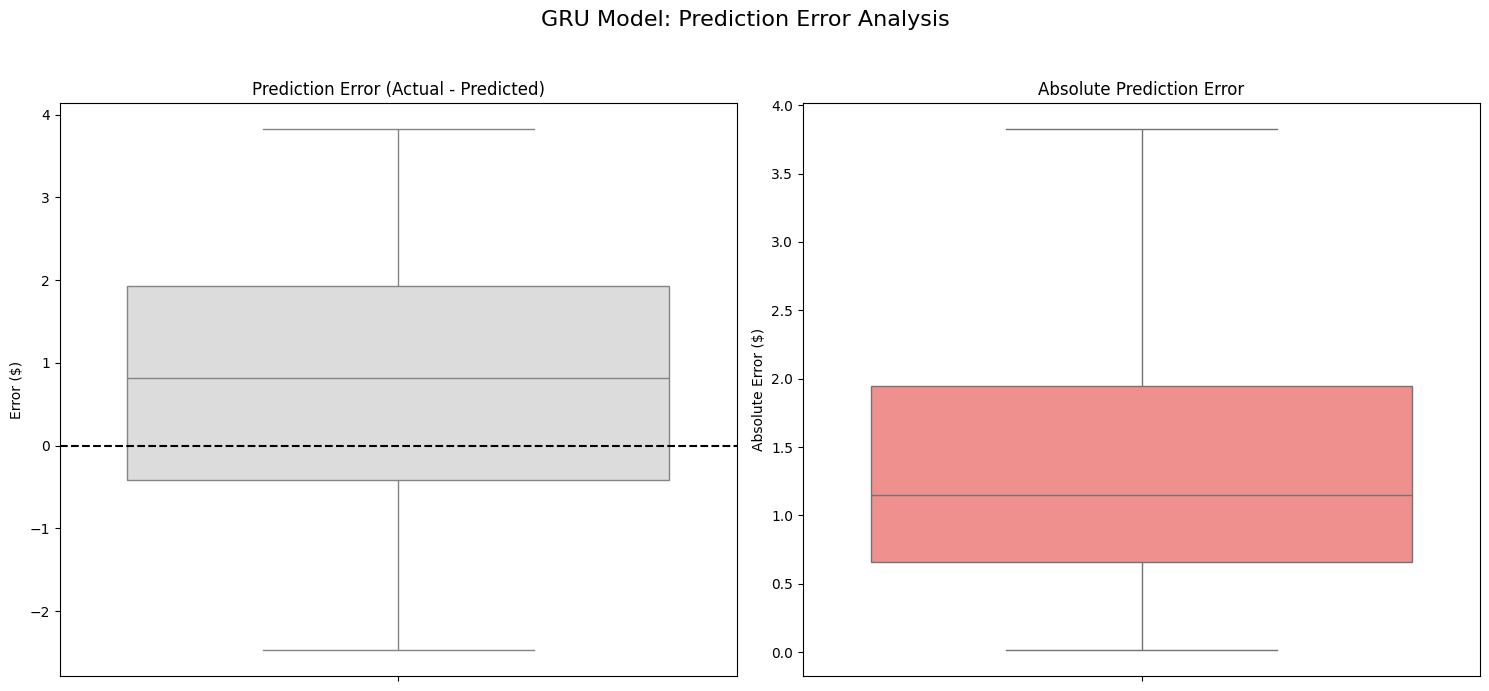



--- Boxplot Analysis Menu ---
Select the type of analysis:
1: Historical Data Analysis
2: Prediction Error Analysis
q: Quit

Select a model to analyze:
1: LSTM
2: GRU
3: RNN


C:\Users\Admin\AppData\Local\Temp\ipykernel_19668\2258369454.py:95: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(ax=ax1, y=results_df['Error'], palette='coolwarm')
C:\Users\Admin\AppData\Local\Temp\ipykernel_19668\2258369454.py:101: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(ax=ax2, y=results_df['Absolute_Error'], palette='spring')


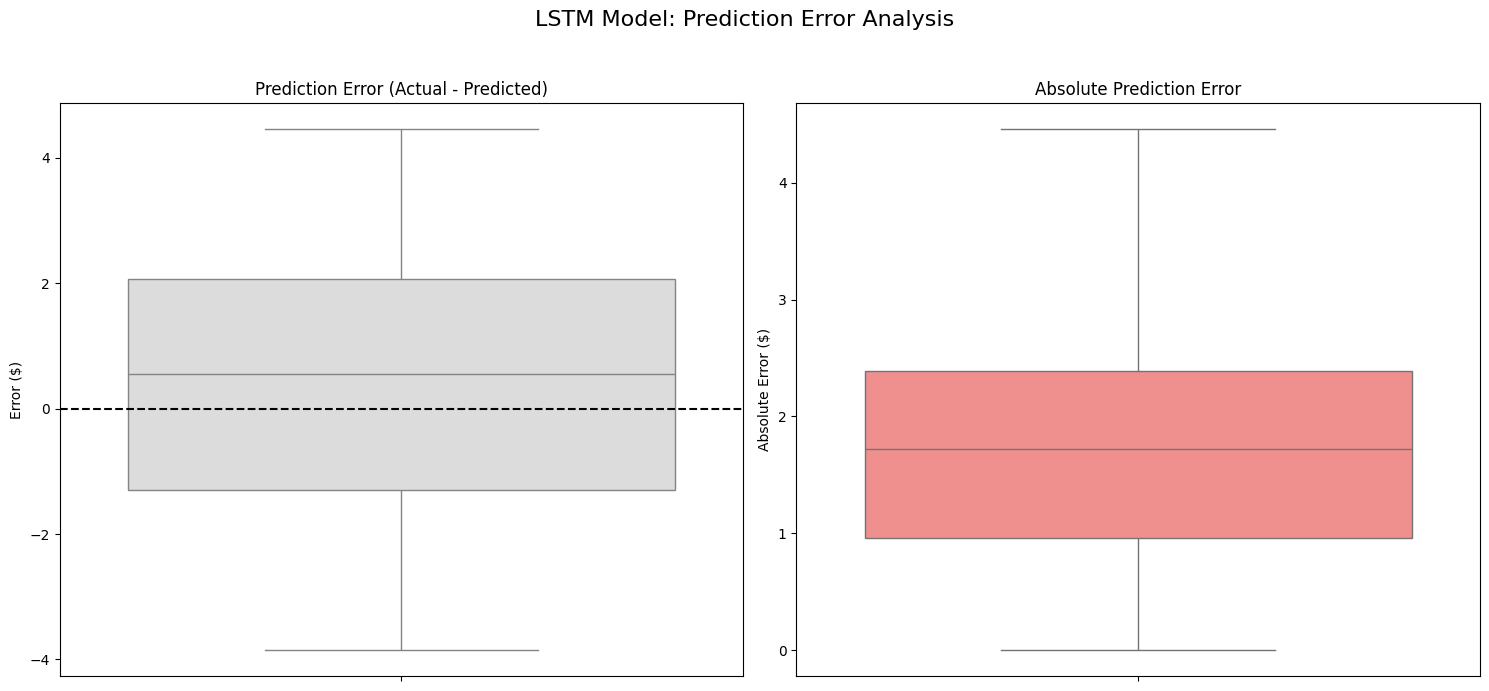



--- Boxplot Analysis Menu ---
Select the type of analysis:
1: Historical Data Analysis
2: Prediction Error Analysis
q: Quit

Select a model to analyze:
1: LSTM
2: GRU
3: RNN


C:\Users\Admin\AppData\Local\Temp\ipykernel_19668\2258369454.py:95: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(ax=ax1, y=results_df['Error'], palette='coolwarm')
C:\Users\Admin\AppData\Local\Temp\ipykernel_19668\2258369454.py:101: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(ax=ax2, y=results_df['Absolute_Error'], palette='spring')


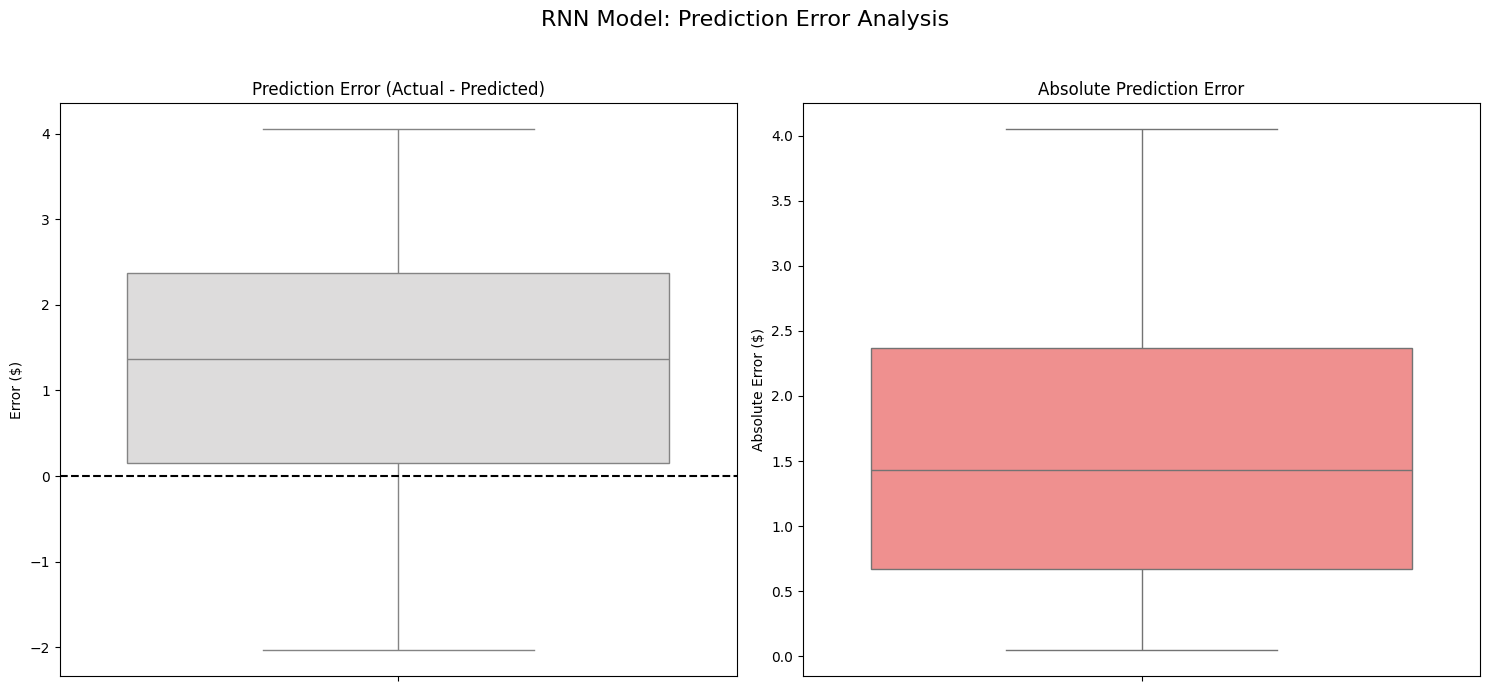



--- Boxplot Analysis Menu ---
Select the type of analysis:
1: Historical Data Analysis
2: Prediction Error Analysis
q: Quit
Exiting boxplot analysis.


In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# --- Function to Prepare Data for Boxplots ---
def create_boxplot_data(df, period='monthly'):
    """
    Prepares and groups historical stock data for boxplot visualization.

    Args:
        df (pd.DataFrame): DataFrame with historical stock data.
        period (str): The time period to group by ('monthly', 'quarterly', 'yearly', 'weekly').

    Returns:
        pd.DataFrame: A DataFrame with an added 'Period' column for grouping.
    """
    df_copy = df.copy()
    
    # Ensure 'Date' column is in datetime format
    df_copy['Date'] = pd.to_datetime(df_copy['Date'])
    
    # Create a period label for grouping
    if period == 'monthly':
        df_copy['Period'] = df_copy['Date'].dt.strftime('%Y-%m')
    elif period == 'quarterly':
        df_copy['Period'] = df_copy['Date'].dt.to_period('Q').astype(str)
    elif period == 'yearly':
        df_copy['Period'] = df_copy['Date'].dt.year.astype(str)
    elif period == 'weekly':
        df_copy['Period'] = df_copy['Date'].dt.strftime('%Y-W%U')
    else:
        raise ValueError("Period must be one of 'monthly', 'quarterly', 'yearly', or 'weekly'")
    
    # Calculate additional metrics for plotting
    df_copy['Price_Range'] = df_copy['High'] - df_copy['Low']
    df_copy['Daily_Return'] = df_copy['Close'].pct_change() * 100
    
    return df_copy

# --- Function to Plot Historical Price Boxplots ---
def plot_price_boxplots(df, period='monthly'):
    """
    Creates a 2x2 grid of boxplots for comprehensive historical stock price analysis.
    """
    boxplot_data = create_boxplot_data(df, period)
    
    if boxplot_data.empty:
        print("No data available for plotting.")
        return

    fig, axes = plt.subplots(2, 2, figsize=(18, 14))
    fig.suptitle(f'Historical Stock Analysis by {period.title()}', fontsize=16)
    
    # Plot 1: Close Price Distribution
    sns.boxplot(ax=axes[0, 0], data=boxplot_data, x='Period', y='Close', palette='viridis')
    axes[0, 0].set_title('Close Price Distribution')
    axes[0, 0].tick_params(axis='x', rotation=45)
    
    # Plot 2: Daily Price Range (Volatility)
    sns.boxplot(ax=axes[0, 1], data=boxplot_data, x='Period', y='Price_Range', palette='plasma')
    axes[0, 1].set_title('Daily Price Range (Volatility)')
    axes[0, 1].tick_params(axis='x', rotation=45)

    # Plot 3: Trading Volume
    sns.boxplot(ax=axes[1, 0], data=boxplot_data, x='Period', y='Volume', palette='magma')
    axes[1, 0].set_title('Trading Volume Distribution')
    axes[1, 0].tick_params(axis='x', rotation=45)
    
    # Plot 4: Daily Returns
    sns.boxplot(ax=axes[1, 1], data=boxplot_data, x='Period', y='Daily_Return', palette='cividis')
    axes[1, 1].set_title('Daily Returns Distribution (%)')
    axes[1, 1].axhline(0, color='black', linestyle='--')
    axes[1, 1].tick_params(axis='x', rotation=45)

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

# --- Function to Plot Prediction Error Boxplots ---
def plot_prediction_error_boxplots(results_df, model_name):
    """
    Creates boxplots for analyzing the errors of a prediction model.
    """
    if results_df.empty:
        print("No prediction data available for plotting.")
        return
        
    results_df['Error'] = results_df['Actual_Price'] - results_df['Predicted_Price']
    results_df['Absolute_Error'] = np.abs(results_df['Error'])

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 7))
    fig.suptitle(f'{model_name} Model: Prediction Error Analysis', fontsize=16)

    # Plot 1: Prediction Error
    sns.boxplot(ax=ax1, y=results_df['Error'], palette='coolwarm')
    ax1.axhline(0, color='black', linestyle='--')
    ax1.set_title('Prediction Error (Actual - Predicted)')
    ax1.set_ylabel('Error ($)')

    # Plot 2: Absolute Prediction Error
    sns.boxplot(ax=ax2, y=results_df['Absolute_Error'], palette='spring')
    ax2.set_title('Absolute Prediction Error')
    ax2.set_ylabel('Absolute Error ($)')

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

# --- Interactive Loop for Boxplot Generation ---
while True:
    print("\n\n--- Boxplot Analysis Menu ---")
    print("Select the type of analysis:")
    print("1: Historical Data Analysis")
    print("2: Prediction Error Analysis")
    print("q: Quit")
    
    main_choice = input("Enter your choice (1/2/q): ").strip().lower()

    if main_choice == 'q':
        print("Exiting boxplot analysis.")
        break

    try:
        if main_choice == '1':
            # --- Historical Analysis ---
            print("\nSelect a period for historical analysis:")
            print("1: Monthly")
            print("2: Quarterly")
            print("3: Yearly")
            print("4: Weekly")
            period_choice = input("Enter your choice [default: 1]: ").strip()
            
            period_map = {'1': 'monthly', '2': 'quarterly', '3': 'yearly', '4': 'weekly'}
            period = period_map.get(period_choice, 'monthly') # Default to monthly
            
            # Combine train and test data to get the full historical dataset
            if 'train_data' not in locals() or 'test_data' not in locals():
                raise NameError("'train_data' or 'test_data' not found.")
            
            full_historical_df = pd.concat([train_data, test_data], ignore_index=True)
            plot_price_boxplots(full_historical_df, period=period)

        elif main_choice == '2':
            # --- Prediction Analysis ---
            print("\nSelect a model to analyze:")
            print("1: LSTM")
            print("2: GRU")
            print("3: RNN")
            model_choice = input("Enter your choice [default: 1]: ").strip()

            model_map = {'1': 'LSTM', '2': 'GRU', '3': 'RNN'}
            model_name = model_map.get(model_choice, 'LSTM') # Default to LSTM

            if 'actual_prices' not in locals() or 'descaled_predictions' not in locals():
                raise NameError("Prediction data not found.")
            
            prediction_df = pd.DataFrame({
                'Actual_Price': actual_prices.flatten(),
                'Predicted_Price': descaled_predictions[model_name].flatten()
            })
            plot_prediction_error_boxplots(prediction_df, model_name)

        else:
            print("❌ Invalid choice. Please try again.")

    except (NameError, KeyError, ValueError) as e:
        print(f"❌ An error occurred: {e}")
        print("Please make sure all prerequisite cells for data loading and model prediction have been run.")
